In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    lens = []
    printed_15, printed_14, printed_13 = [False] * 3
    for model in model_val_list:
        lens.append(len(model))
        if len(model) == 15 and not printed_15:
            print(model)
            printed_15 = True
        if len(model) == 14 and not printed_14:
            print(model)
            printed_14 = True
        if len(model) == 13 and not printed_13:
            print(model)
            printed_13 = True
    print('Lengths', set(lens))
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std performance and number of runs for each model 
    #('count', lambda x: x.sample(frac = 1).head(5).shape[0])

    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).mean()), 
                 ('std', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).std()), 
                ('count', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).shape[0])]
    # ['mean', 'std', 'count']
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == 0.1)]
#     df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[((df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)) | (df['ratio'] == 0 )]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>=0) & (df['ProbVLM']=='False') & (df['AL.epochs']<=20)]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP,  #'baseline-not-finetuned' : df_no_finetune, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
validation_path = './eval.txt'
df_grouped = prep_and_store_results(validation_path)

['RS.ALL', '0.1', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64', '0']
Lengths {14}
Number of evaluations: 53410
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


value  \
                                                                                              mean   
ratio PL   dataset method metric            bs lr      AL.epochs epochs AL.iter ProbVLM              
0.1   None RSICD   base   image_to_text_R@1 32 0.00005 5.0       5      5.0     True      3.756667   
                                                                        10.0    True      3.206667   
                                                                        20.0    True      2.960000   
                                                                 10     5.0     True      4.606667   
                                                                        10.0    True      4.670000   
...                                                                                            ...   
0.7   None UCM     base   text_to_image_R@5 64 0.00005 NaN       10     NaN     False    65.990000   
                                                                 15     NaN     False    68.345000   
           UCM-CLS base   zeroshot-val-top1 64 0.00005 NaN       5      NaN     False    78.187500   
                                                                 10     NaN     False    78.397500   
                                                                 15     NaN     False    77.972500   

                                                                                                   \
                                                                                              std   
ratio PL   dataset method metric            bs lr      AL.epochs epochs AL.iter ProbVLM             
0.1   None RSICD   base   image_to_text_R@1 32 0.00005 5.0       5      5.0     True     0.641431   
                                                                        10.0    True     0.330051   
                                                                        20.0    True     0.350000   
                                                                 10     5.0     True     0.531162   
                                                                        10.0    True     0.885042   
...                                                                                           ...   
0.7   None UCM     base   text_to_image_R@5 64 0.00005 NaN       10     NaN     False    2.642385   
                                                                 15     NaN     False    1.715605   
           UCM-CLS base   zeroshot-val-top1 64 0.00005 NaN       5      NaN     False    5.256433   
                                                                 10     NaN     False    3.115032   
                                                                 15     NaN     False    3.209884   

                                                                                               
                                                                                        count  
ratio PL   dataset method metric            bs lr      AL.epochs epochs AL.iter ProbVLM        
0.1   None RSICD   base   image_to_text_R@1 32 0.00005 5.0       5      5.0     True        3  
                                                                        10.0    True        3  
                                                                        20.0    True        3  
                                                                 10     5.0     True        3  
                                                                        10.0    True        3  
...                                                                                       ...  
0.7   None UCM     base   text_to_image_R@5 64 0.00005 NaN       10     NaN     False       4  
                                                                 15     NaN     False       4  
           UCM-CLS base   zeroshot-val-top1 64 0.00005 NaN       5      NaN     False       4  
                                                                 10     NaN     False       4  
 

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

ratio         PL  dataset method             metric   bs       lr  \
                                                                         
7034   0.1  soft.text    RSICD   ours  image_to_text_R@1   64  0.00050   
7039   0.1  soft.text    RSICD   ours  image_to_text_R@1   64  0.00050   
3701   0.1  hard.text    RSICD   ours  image_to_text_R@1  128  0.00050   
4514   0.1   ot.image    RSICD   ours  image_to_text_R@1   64  0.00050   
4518   0.1   ot.image    RSICD   ours  image_to_text_R@1   64  0.00050   
...    ...        ...      ...    ...                ...  ...      ...   
7977   0.5       None  UCM-CLS   base  zeroshot-val-top1   64  0.00005   
8039   0.7       None  UCM-CLS   base  zeroshot-val-top1   64  0.00005   
8037   0.7       None  UCM-CLS   base  zeroshot-val-top1   64  0.00005   
7979   0.5       None  UCM-CLS   base  zeroshot-val-top1   64  0.00005   
8038   0.7       None  UCM-CLS   base  zeroshot-val-top1   64  0.00005   

     AL.epochs epochs AL.iter ProbVLM    value                  
                                          mean       std count  
7034       5.0      5     NaN   False   0.0675  0.045000     4  
7039      30.0     30     NaN   False   0.0675  0.045000     4  
3701      35.0     35     NaN   False   0.0700  0.039686     9  
4514       5.0      5     NaN   False   0.0700  0.060000     9  
4518      25.0     25     NaN   False   0.0800  0.030000     9  
...        ...    ...     ...     ...      ...       ...   ...  
7977       5.0      5     NaN   False  77.7550  3.436680     4  
8039      15.0     15     NaN   False  77.9725  3.209884     4  
8037       5.0      5     NaN   False  78.1875  5.256433     4  
7979      15.0     15     NaN   False  78.2875  3.939225     4  
8038      10.0     10     NaN   False  78.3975  3.115032     4  

[8040 rows x 14 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
full_display(df_probvlm_AL.groupby(['metric', 'dataset']).tail(3))

ratio    PL    dataset method              metric  bs       lr AL.epochs  \
                                                                                
11     0.1  None      RSICD   base   image_to_text_R@1  32  0.00005       5.0   
27     0.1  None      RSICD   base   image_to_text_R@1  32  0.00005      20.0   
21     0.1  None      RSICD   base   image_to_text_R@1  32  0.00005      10.0   
1002   0.1  None     Sydney   base   image_to_text_R@1  32  0.00005      10.0   
994    0.1  None     Sydney   base   image_to_text_R@1  32  0.00005       5.0   
1019   0.1  None     Sydney   base   image_to_text_R@1  32  0.00005      20.0   
1871   0.1  None        UCM   base   image_to_text_R@1  32  0.00005      20.0   
1857   0.1  None        UCM   base   image_to_text_R@1  32  0.00005      10.0   
1869   0.1  None        UCM   base   image_to_text_R@1  32  0.00005      20.0   
160    0.1  None      RSICD   base  image_to_text_R@10  32  0.00005      10.0   
148    0.1  None      RSICD   base  image_to_text_R@10  32  0.00005       5.0   
163    0.1  None      RSICD   base  image_to_text_R@10  32  0.00005      10.0   
1157   0.1  None     Sydney   base  image_to_text_R@10  32  0.00005      20.0   
1159   0.1  None     Sydney   base  image_to_text_R@10  32  0.00005      20.0   
1161   0.1  None     Sydney   base  image_to_text_R@10  32  0.00005      20.0   
2000   0.1  None        UCM   base  image_to_text_R@10  32  0.00005      10.0   
1982   0.1  None        UCM   base  image_to_text_R@10  32  0.00005       5.0   
1981   0.1  None        UCM   base  image_to_text_R@10  32  0.00005       5.0   
294    0.1  None      RSICD   base   image_to_text_R@5  32  0.00005       5.0   
292    0.1  None      RSICD   base   image_to_text_R@5  32  0.00005       5.0   
305    0.1  None      RSICD   base   image_to_text_R@5  32  0.00005      10.0   
1302   0.1  None     Sydney   base   image_to_text_R@5  32  0.00005      20.0   
1303   0.1  None     Sydney   base   image_to_text_R@5  32  0.00005      20.0   
1301   0.1  None     Sydney   base   image_to_text_R@5  32  0.00005      20.0   
2155   0.1  None        UCM   base   image_to_text_R@5  32  0.00005      20.0   
2142   0.1  None        UCM   base   image_to_text_R@5  32  0.00005      10.0   
2153   0.1  None        UCM   base   image_to_text_R@5  32  0.00005      20.0   
446    0.1  None      RSICD   base   text_to_image_R@1  32  0.00005      10.0   
432    0.1  None      RSICD   base   text_to_image_R@1  32  0.00005       5.0   
447    0.1  None      RSICD   base   text_to_image_R@1  32  0.00005      10.0   
1432   0.1  None     Sydney   base   text_to_image_R@1  32  0.00005      10.0   
1445   0.1  None     Sydney   base   text_to_image_R@1  32  0.00005      20.0   
1443   0.1  None     Sydney   base   text_to_image_R@1  32  0.00005      20.0   
2292   0.1  None        UCM   base   text_to_image_R@1  32  0.00005      20.0   
2272   0.1  None        UCM   base   text_to_image_R@1  32  0.00005       5.0   
2271   0.1  None        UCM   base   text_to_image_R@1  32  0.00005       5.0   
601    0.1  None      RSICD   base  text_to_image_R@10  32  0.00005      20.0   
571    0.1  None      RSICD   base  text_to_image_R@10  32  0.00005       5.0   
589    0.1  None      RSICD   base  text_to_image_R@10  32  0.00005      10.0   
1573   0.1  None     Sydney   base  text_to_image_R@10  32  0.00005      10.0   
1587   0.1  None     Sydney   base  text_to_image_R@10  32  0.00005      20.0   
1585   0.1  None     Sydney   base  text_to_image_R@10  32  0.00005      20.0   
2413   0.1  None        UCM   base  text_to_image_R@10  32  0.00005       5.0   
2426   0.1  None        UCM   base  text_to_image_R@10  32  0.00005      10.0   
2437   0.1  None        UCM   base  text_to_image_R@10  32  0.00005      20.0   
721    0.1  None      RSICD   base   text_to_image_R@5  32  0.00005       5.0   
730    0.1  None      RSICD   base   text_to_image_R@5  32  0.00005      10.0   
731    0.1  None      RSICD   base  

In [7]:
# Results with basic active learning
full_display(df_basic_AL.groupby(['metric', 'dataset']).tail(3)) 

ratio    PL    dataset method              metric  bs       lr AL.epochs  \
                                                                                
55     0.1  None      RSICD   base   image_to_text_R@1  64  0.00005       5.0   
65     0.1  None      RSICD   base   image_to_text_R@1  64  0.00005      10.0   
66     0.1  None      RSICD   base   image_to_text_R@1  64  0.00005      10.0   
1063   0.1  None     Sydney   base   image_to_text_R@1  64  0.00005      20.0   
1068   0.1  None     Sydney   base   image_to_text_R@1  64  0.00005      20.0   
1065   0.1  None     Sydney   base   image_to_text_R@1  64  0.00005      20.0   
1916   0.1  None        UCM   base   image_to_text_R@1  64  0.00005      20.0   
1891   0.1  None        UCM   base   image_to_text_R@1  64  0.00005       5.0   
1915   0.1  None        UCM   base   image_to_text_R@1  64  0.00005      20.0   
200    0.1  None      RSICD   base  image_to_text_R@10  64  0.00005      10.0   
197    0.1  None      RSICD   base  image_to_text_R@10  64  0.00005       5.0   
207    0.1  None      RSICD   base  image_to_text_R@10  64  0.00005      10.0   
1191   0.1  None     Sydney   base  image_to_text_R@10  64  0.00005      10.0   
1210   0.1  None     Sydney   base  image_to_text_R@10  64  0.00005      20.0   
1207   0.1  None     Sydney   base  image_to_text_R@10  64  0.00005      20.0   
2038   0.1  None        UCM   base  image_to_text_R@10  64  0.00005      10.0   
2055   0.1  None        UCM   base  image_to_text_R@10  64  0.00005      20.0   
2033   0.1  None        UCM   base  image_to_text_R@10  64  0.00005       5.0   
363    0.1  None      RSICD   base   image_to_text_R@5  64  0.00005      20.0   
350    0.1  None      RSICD   base   image_to_text_R@5  64  0.00005      10.0   
349    0.1  None      RSICD   base   image_to_text_R@5  64  0.00005      10.0   
1350   0.1  None     Sydney   base   image_to_text_R@5  64  0.00005      20.0   
1352   0.1  None     Sydney   base   image_to_text_R@5  64  0.00005      20.0   
1349   0.1  None     Sydney   base   image_to_text_R@5  64  0.00005      20.0   
2180   0.1  None        UCM   base   image_to_text_R@5  64  0.00005      10.0   
2197   0.1  None        UCM   base   image_to_text_R@5  64  0.00005      20.0   
2175   0.1  None        UCM   base   image_to_text_R@5  64  0.00005       5.0   
495    0.1  None      RSICD   base   text_to_image_R@1  64  0.00005      10.0   
510    0.1  None      RSICD   base   text_to_image_R@1  64  0.00005      20.0   
508    0.1  None      RSICD   base   text_to_image_R@1  64  0.00005      20.0   
1475   0.1  None     Sydney   base   text_to_image_R@1  64  0.00005      10.0   
1491   0.1  None     Sydney   base   text_to_image_R@1  64  0.00005      20.0   
1494   0.1  None     Sydney   base   text_to_image_R@1  64  0.00005      20.0   
2344   0.1  None        UCM   base   text_to_image_R@1  64  0.00005      20.0   
2342   0.1  None        UCM   base   text_to_image_R@1  64  0.00005      20.0   
2346   0.1  None        UCM   base   text_to_image_R@1  64  0.00005      20.0   
634    0.1  None      RSICD   base  text_to_image_R@10  64  0.00005      10.0   
623    0.1  None      RSICD   base  text_to_image_R@10  64  0.00005       5.0   
633    0.1  None      RSICD   base  text_to_image_R@10  64  0.00005      10.0   
1622   0.1  None     Sydney   base  text_to_image_R@10  64  0.00005      10.0   
1632   0.1  None     Sydney   base  text_to_image_R@10  64  0.00005      20.0   
1633   0.1  None     Sydney   base  text_to_image_R@10  64  0.00005      20.0   
2488   0.1  None        UCM   base  text_to_image_R@10  64  0.00005      20.0   
2468   0.1  None        UCM   base  text_to_image_R@10  64  0.00005      10.0   
2481   0.1  None        UCM   base  text_to_image_R@10  64  0.00005      20.0   
765    0.1  None      RSICD   base   text_to_image_R@5  64  0.00005       5.0   
785    0.1  None      RSICD   base   text_to_image_R@5  64  0.00005      20.0   
775    0.1  None      RSICD   base  

In [8]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

ratio    PL    dataset method              metric   bs       lr  \
                                                                       
101    0.1  None      RSICD   base   image_to_text_R@1   64  0.00005   
103    0.1  None      RSICD   base   image_to_text_R@1   64  0.00005   
102    0.1  None      RSICD   base   image_to_text_R@1   64  0.00005   
1086   0.1  None     Sydney   base   image_to_text_R@1   64  0.00005   
1117   0.1  None     Sydney   base   image_to_text_R@1  128  0.00005   
1118   0.1  None     Sydney   base   image_to_text_R@1  128  0.00005   
1939   0.1  None        UCM   base   image_to_text_R@1   64  0.00005   
1968   0.1  None        UCM   base   image_to_text_R@1  128  0.00005   
1938   0.1  None        UCM   base   image_to_text_R@1   64  0.00005   
244    0.1  None      RSICD   base  image_to_text_R@10   64  0.00005   
243    0.1  None      RSICD   base  image_to_text_R@10   64  0.00005   
245    0.1  None      RSICD   base  image_to_text_R@10   64  0.00005   
1259   0.1  None     Sydney   base  image_to_text_R@10  128  0.00005   
1228   0.1  None     Sydney   base  image_to_text_R@10   64  0.00005   
1229   0.1  None     Sydney   base  image_to_text_R@10   64  0.00005   
2081   0.1  None        UCM   base  image_to_text_R@10   64  0.00005   
2112   0.1  None        UCM   base  image_to_text_R@10  128  0.00005   
2111   0.1  None        UCM   base  image_to_text_R@10  128  0.00005   
385    0.1  None      RSICD   base   image_to_text_R@5   64  0.00005   
386    0.1  None      RSICD   base   image_to_text_R@5   64  0.00005   
387    0.1  None      RSICD   base   image_to_text_R@5   64  0.00005   
1370   0.1  None     Sydney   base   image_to_text_R@5   64  0.00005   
1401   0.1  None     Sydney   base   image_to_text_R@5  128  0.00005   
1402   0.1  None     Sydney   base   image_to_text_R@5  128  0.00005   
2254   0.1  None        UCM   base   image_to_text_R@5  128  0.00005   
2223   0.1  None        UCM   base   image_to_text_R@5   64  0.00005   
2253   0.1  None        UCM   base   image_to_text_R@5  128  0.00005   
527    0.1  None      RSICD   base   text_to_image_R@1   64  0.00005   
528    0.1  None      RSICD   base   text_to_image_R@1   64  0.00005   
529    0.1  None      RSICD   base   text_to_image_R@1   64  0.00005   
1542   0.1  None     Sydney   base   text_to_image_R@1  128  0.00005   
1543   0.1  None     Sydney   base   text_to_image_R@1  128  0.00005   
1544   0.1  None     Sydney   base   text_to_image_R@1  128  0.00005   
2364   0.1  None        UCM   base   text_to_image_R@1   64  0.00005   
2395   0.1  None        UCM   base   text_to_image_R@1  128  0.00005   
2396   0.1  None        UCM   base   text_to_image_R@1  128  0.00005   
669    0.1  None      RSICD   base  text_to_image_R@10   64  0.00005   
671    0.1  None      RSICD   base  text_to_image_R@10   64  0.00005   
670    0.1  None      RSICD   base  text_to_image_R@10   64  0.00005   
1686   0.1  None     Sydney   base  text_to_image_R@10  128  0.00005   
1655   0.1  None     Sydney   base  text_to_image_R@10   64  0.00005   
1654   0.1  None     Sydney   base  text_to_image_R@10   64  0.00005   
2538   0.1  None        UCM   base  text_to_image_R@10  128  0.00005   
2506   0.1  None        UCM   base  text_to_image_R@10   64  0.00005   
2507   0.1  None        UCM   base  text_to_image_R@10   64  0.00005   
811    0.1  None      RSICD   base   text_to_image_R@5   64  0.00005   
813    0.1  None      RSICD   base   text_to_image_R@5   64  0.00005   
812    0.1  None      RSICD   base   text_to_image_R@5   64  0.00005   
1827   0.1  None     Sydney   base   text_to_image_R@5  128  0.00005   
1797   0.1  None     Sydney   base   text_to_image_R@5   64  0.00005   
1828   0.1  None     Sydney   base   text_to_image_R@5  128  0.00005   
2649   0.1  None        UCM   base   text_to_image_R@5   64  0.00005   
2648   0.1  None        UCM   base   text_to_image_R@5   64  0.00005   
2647   0.1  None        UCM   base   text_to_

In [9]:
full_display(df_S_CLIP.groupby(['metric', 'dataset']).tail(3))

ratio        PL    dataset method              metric   bs       lr  \
                                                                           
4532   0.1  ot.image      RSICD   ours   image_to_text_R@1  128  0.00005   
4533   0.1  ot.image      RSICD   ours   image_to_text_R@1  128  0.00005   
4534   0.1  ot.image      RSICD   ours   image_to_text_R@1  128  0.00005   
4824   0.1  ot.image     Sydney   ours   image_to_text_R@1  128  0.00005   
4827   0.1  ot.image     Sydney   ours   image_to_text_R@1  128  0.00005   
4828   0.1  ot.image     Sydney   ours   image_to_text_R@1  128  0.00005   
5078   0.1  ot.image        UCM   ours   image_to_text_R@1  128  0.00005   
5079   0.1  ot.image        UCM   ours   image_to_text_R@1  128  0.00005   
5080   0.1  ot.image        UCM   ours   image_to_text_R@1  128  0.00005   
4574   0.1  ot.image      RSICD   ours  image_to_text_R@10  128  0.00005   
4576   0.1  ot.image      RSICD   ours  image_to_text_R@10  128  0.00005   
4575   0.1  ot.image      RSICD   ours  image_to_text_R@10  128  0.00005   
4868   0.1  ot.image     Sydney   ours  image_to_text_R@10  128  0.00005   
4869   0.1  ot.image     Sydney   ours  image_to_text_R@10  128  0.00005   
4870   0.1  ot.image     Sydney   ours  image_to_text_R@10  128  0.00005   
5101   0.1  ot.image        UCM   ours  image_to_text_R@10   64  0.00005   
5121   0.1  ot.image        UCM   ours  image_to_text_R@10  128  0.00005   
5122   0.1  ot.image        UCM   ours  image_to_text_R@10  128  0.00005   
4616   0.1  ot.image      RSICD   ours   image_to_text_R@5  128  0.00005   
4617   0.1  ot.image      RSICD   ours   image_to_text_R@5  128  0.00005   
4618   0.1  ot.image      RSICD   ours   image_to_text_R@5  128  0.00005   
4890   0.1  ot.image     Sydney   ours   image_to_text_R@5   64  0.00005   
4911   0.1  ot.image     Sydney   ours   image_to_text_R@5  128  0.00005   
4912   0.1  ot.image     Sydney   ours   image_to_text_R@5  128  0.00005   
5164   0.1  ot.image        UCM   ours   image_to_text_R@5  128  0.00005   
5163   0.1  ot.image        UCM   ours   image_to_text_R@5  128  0.00005   
5162   0.1  ot.image        UCM   ours   image_to_text_R@5  128  0.00005   
4659   0.1  ot.image      RSICD   ours   text_to_image_R@1  128  0.00005   
4660   0.1  ot.image      RSICD   ours   text_to_image_R@1  128  0.00005   
4639   0.1  ot.image      RSICD   ours   text_to_image_R@1   64  0.00005   
4954   0.1  ot.image     Sydney   ours   text_to_image_R@1  128  0.00005   
4953   0.1  ot.image     Sydney   ours   text_to_image_R@1  128  0.00005   
4952   0.1  ot.image     Sydney   ours   text_to_image_R@1  128  0.00005   
5204   0.1  ot.image        UCM   ours   text_to_image_R@1  128  0.00005   
5205   0.1  ot.image        UCM   ours   text_to_image_R@1  128  0.00005   
5206   0.1  ot.image        UCM   ours   text_to_image_R@1  128  0.00005   
4700   0.1  ot.image      RSICD   ours  text_to_image_R@10  128  0.00005   
4701   0.1  ot.image      RSICD   ours  text_to_image_R@10  128  0.00005   
4702   0.1  ot.image      RSICD   ours  text_to_image_R@10  128  0.00005   
4994   0.1  ot.image     Sydney   ours  text_to_image_R@10  128  0.00005   
4995   0.1  ot.image     Sydney   ours  text_to_image_R@10  128  0.00005   
4996   0.1  ot.image     Sydney   ours  text_to_image_R@10  128  0.00005   
5247   0.1  ot.image        UCM   ours  text_to_image_R@10  128  0.00005   
5227   0.1  ot.image        UCM   ours  text_to_image_R@10   64  0.00005   
5248   0.1  ot.image        UCM   ours  text_to_image_R@10  128  0.00005   
4742   0.1  ot.image      RSICD   ours   text_to_image_R@5  128  0.00005   
4744   0.1  ot.image      RSICD   ours   text_to_image_R@5  128  0.00005   
4743   0.1  ot.image      RSICD   ours   text_to_image_R@5  128  0.00005   
5036   0.1  ot.image     Sydney   ours   text_to_image_R@5  128  0.00005   
5037   0.1  ot.image     Sydney   ours   text_to_image_R@5  128  0.00005   
5038   0.1  ot.image     Sydney   ours   text_to_imag

In [10]:
full_display(df_soft_PL.groupby(['metric', 'dataset']).tail(3))

ratio          PL    dataset method              metric   bs       lr  \
                                                                             
7032   0.1   soft.text      RSICD   ours   image_to_text_R@1   64  0.00005   
6213   0.1  soft.image      RSICD   ours   image_to_text_R@1  128  0.00005   
7033   0.1   soft.text      RSICD   ours   image_to_text_R@1   64  0.00005   
6507   0.1  soft.image     Sydney   ours   image_to_text_R@1  128  0.00005   
7327   0.1   soft.text     Sydney   ours   image_to_text_R@1   64  0.00005   
6508   0.1  soft.image     Sydney   ours   image_to_text_R@1  128  0.00005   
7599   0.1   soft.text        UCM   ours   image_to_text_R@1  128  0.00005   
7579   0.1   soft.text        UCM   ours   image_to_text_R@1   64  0.00005   
7600   0.1   soft.text        UCM   ours   image_to_text_R@1  128  0.00005   
7096   0.1   soft.text      RSICD   ours  image_to_text_R@10  128  0.00005   
7075   0.1   soft.text      RSICD   ours  image_to_text_R@10   64  0.00005   
7074   0.1   soft.text      RSICD   ours  image_to_text_R@10   64  0.00005   
7367   0.1   soft.text     Sydney   ours  image_to_text_R@10   64  0.00005   
7389   0.1   soft.text     Sydney   ours  image_to_text_R@10  128  0.00005   
7390   0.1   soft.text     Sydney   ours  image_to_text_R@10  128  0.00005   
6800   0.1  soft.image        UCM   ours  image_to_text_R@10  128  0.00005   
7621   0.1   soft.text        UCM   ours  image_to_text_R@10   64  0.00005   
7620   0.1   soft.text        UCM   ours  image_to_text_R@10   64  0.00005   
7138   0.1   soft.text      RSICD   ours   image_to_text_R@5  128  0.00005   
7116   0.1   soft.text      RSICD   ours   image_to_text_R@5   64  0.00005   
7117   0.1   soft.text      RSICD   ours   image_to_text_R@5   64  0.00005   
6592   0.1  soft.image     Sydney   ours   image_to_text_R@5  128  0.00005   
7431   0.1   soft.text     Sydney   ours   image_to_text_R@5  128  0.00005   
7432   0.1   soft.text     Sydney   ours   image_to_text_R@5  128  0.00005   
7683   0.1   soft.text        UCM   ours   image_to_text_R@5  128  0.00005   
7662   0.1   soft.text        UCM   ours   image_to_text_R@5   64  0.00005   
7663   0.1   soft.text        UCM   ours   image_to_text_R@5   64  0.00005   
7180   0.1   soft.text      RSICD   ours   text_to_image_R@1  128  0.00005   
7158   0.1   soft.text      RSICD   ours   text_to_image_R@1   64  0.00005   
7179   0.1   soft.text      RSICD   ours   text_to_image_R@1  128  0.00005   
7472   0.1   soft.text     Sydney   ours   text_to_image_R@1  128  0.00005   
6633   0.1  soft.image     Sydney   ours   text_to_image_R@1  128  0.00005   
7474   0.1   soft.text     Sydney   ours   text_to_image_R@1  128  0.00005   
6884   0.1  soft.image        UCM   ours   text_to_image_R@1  128  0.00005   
7705   0.1   soft.text        UCM   ours   text_to_image_R@1   64  0.00005   
6886   0.1  soft.image        UCM   ours   text_to_image_R@1  128  0.00005   
7222   0.1   soft.text      RSICD   ours  text_to_image_R@10  128  0.00005   
7200   0.1   soft.text      RSICD   ours  text_to_image_R@10   64  0.00005   
7201   0.1   soft.text      RSICD   ours  text_to_image_R@10   64  0.00005   
7515   0.1   soft.text     Sydney   ours  text_to_image_R@10  128  0.00005   
6676   0.1  soft.image     Sydney   ours  text_to_image_R@10  128  0.00005   
7516   0.1   soft.text     Sydney   ours  text_to_image_R@10  128  0.00005   
7745   0.1   soft.text        UCM   ours  text_to_image_R@10   64  0.00005   
7746   0.1   soft.text        UCM   ours  text_to_image_R@10   64  0.00005   
7747   0.1   soft.text        UCM   ours  text_to_image_R@10   64  0.00005   
7263   0.1   soft.text      RSICD   ours   text_to_image_R@5  128  0.00005   
7242   0.1   soft.text      RSICD   ours   text_to_image_R@5   64  0.00005   
7243   0.1   soft.text      RSICD   ours   text_to_image_R@5   64  0.00005   
7557   0.1   soft.text     Sydney   ours   text_to_image_R@5  128  0.00005   
6717   0.1  soft.image     

In [11]:
full_display(df_hard_PL.groupby(['metric', 'dataset']).tail(3))

ratio          PL    dataset method              metric   bs       lr  \
                                                                             
3671   0.1   hard.text      RSICD   ours   image_to_text_R@1   64  0.00005   
3694   0.1   hard.text      RSICD   ours   image_to_text_R@1  128  0.00005   
3673   0.1   hard.text      RSICD   ours   image_to_text_R@1   64  0.00005   
3127   0.1  hard.image     Sydney   ours   image_to_text_R@1   64  0.00005   
3126   0.1  hard.image     Sydney   ours   image_to_text_R@1   64  0.00005   
3965   0.1   hard.text     Sydney   ours   image_to_text_R@1   64  0.00005   
3378   0.1  hard.image        UCM   ours   image_to_text_R@1   64  0.00005   
4239   0.1   hard.text        UCM   ours   image_to_text_R@1  128  0.00005   
4240   0.1   hard.text        UCM   ours   image_to_text_R@1  128  0.00005   
3736   0.1   hard.text      RSICD   ours  image_to_text_R@10  128  0.00005   
3714   0.1   hard.text      RSICD   ours  image_to_text_R@10   64  0.00005   
3715   0.1   hard.text      RSICD   ours  image_to_text_R@10   64  0.00005   
4030   0.1   hard.text     Sydney   ours  image_to_text_R@10  128  0.00005   
4008   0.1   hard.text     Sydney   ours  image_to_text_R@10   64  0.00005   
4009   0.1   hard.text     Sydney   ours  image_to_text_R@10   64  0.00005   
3420   0.1  hard.image        UCM   ours  image_to_text_R@10   64  0.00005   
4261   0.1   hard.text        UCM   ours  image_to_text_R@10   64  0.00005   
4260   0.1   hard.text        UCM   ours  image_to_text_R@10   64  0.00005   
3757   0.1   hard.text      RSICD   ours   image_to_text_R@5   64  0.00005   
3755   0.1   hard.text      RSICD   ours   image_to_text_R@5   64  0.00005   
3756   0.1   hard.text      RSICD   ours   image_to_text_R@5   64  0.00005   
4050   0.1   hard.text     Sydney   ours   image_to_text_R@5   64  0.00005   
4072   0.1   hard.text     Sydney   ours   image_to_text_R@5  128  0.00005   
4049   0.1   hard.text     Sydney   ours   image_to_text_R@5   64  0.00005   
4324   0.1   hard.text        UCM   ours   image_to_text_R@5  128  0.00005   
3463   0.1  hard.image        UCM   ours   image_to_text_R@5   64  0.00005   
4323   0.1   hard.text        UCM   ours   image_to_text_R@5  128  0.00005   
3797   0.1   hard.text      RSICD   ours   text_to_image_R@1   64  0.00005   
3798   0.1   hard.text      RSICD   ours   text_to_image_R@1   64  0.00005   
3799   0.1   hard.text      RSICD   ours   text_to_image_R@1   64  0.00005   
4112   0.1   hard.text     Sydney   ours   text_to_image_R@1  128  0.00005   
4114   0.1   hard.text     Sydney   ours   text_to_image_R@1  128  0.00005   
4113   0.1   hard.text     Sydney   ours   text_to_image_R@1  128  0.00005   
4344   0.1   hard.text        UCM   ours   text_to_image_R@1   64  0.00005   
4366   0.1   hard.text        UCM   ours   text_to_image_R@1  128  0.00005   
3505   0.1  hard.image        UCM   ours   text_to_image_R@1   64  0.00005   
3862   0.1   hard.text      RSICD   ours  text_to_image_R@10  128  0.00005   
3840   0.1   hard.text      RSICD   ours  text_to_image_R@10   64  0.00005   
3841   0.1   hard.text      RSICD   ours  text_to_image_R@10   64  0.00005   
4134   0.1   hard.text     Sydney   ours  text_to_image_R@10   64  0.00005   
4155   0.1   hard.text     Sydney   ours  text_to_image_R@10  128  0.00005   
4156   0.1   hard.text     Sydney   ours  text_to_image_R@10  128  0.00005   
4386   0.1   hard.text        UCM   ours  text_to_image_R@10   64  0.00005   
4385   0.1   hard.text        UCM   ours  text_to_image_R@10   64  0.00005   
4387   0.1   hard.text        UCM   ours  text_to_image_R@10   64  0.00005   
3904   0.1   hard.text      RSICD   ours   text_to_image_R@5  128  0.00005   
3882   0.1   hard.text      RSICD   ours   text_to_image_R@5   64  0.00005   
3883   0.1   hard.text      RSICD   ours   text_to_image_R@5   64  0.00005   
4175   0.1   hard.text     Sydney   ours   text_to_image_R@5   64  0.00005   
4197   0.1   hard.text     

# Test split evaluation results

In [12]:
test_path = './test_eval.txt'
df_grouped = prep_and_store_results(test_path)

['RS.ALL', '0.05', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64']
Lengths {13}
Number of evaluations: 75228
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75223,Sydney,image_to_text_R@5,15.29,0.40,base,True,20.0,10.0,None,25,0.00005,32
75224,Sydney,image_to_text_R@10,23.54,0.40,base,True,20.0,10.0,None,25,0.00005,32
75225,Sydney,text_to_image_R@1,4.83,0.40,base,True,20.0,10.0,None,25,0.00005,32
75226,Sydney,text_to_image_R@5,17.10,0.40,base,True,20.0,10.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75223,Sydney,image_to_text_R@5,15.29,0.40,base,True,20.0,10.0,None,25,0.00005,32
75224,Sydney,image_to_text_R@10,23.54,0.40,base,True,20.0,10.0,None,25,0.00005,32
75225,Sydney,text_to_image_R@1,4.83,0.40,base,True,20.0,10.0,None,25,0.00005,32
75226,Sydney,text_to_image_R@5,17.10,0.40,base,True,20.0,10.0,None,25,0.00005,32


value  \
                                                                                             mean   
ratio PL   dataset  method metric             bs lr      AL.epochs epochs AL.iter ProbVLM           
0.0   None AID      base   zeroshot-val-top1  64 0.00005 NaN       0      NaN     False    52.820   
           RESISC45 base   zeroshot-val-top1  64 0.00005 NaN       0      NaN     False    48.710   
           RSICD    base   image_to_text_R@1  64 0.00005 NaN       0      NaN     False     3.480   
                           image_to_text_R@10 64 0.00005 NaN       0      NaN     False    20.590   
                           image_to_text_R@5  64 0.00005 NaN       0      NaN     False    12.530   
...                                                                                           ...   
1.0   None WHU-RS19 base   zeroshot-val-top1  64 0.00005 NaN       21     NaN     False    94.032   
                                                                   22     NaN     False    93.612   
                                                                   23     NaN     False    93.772   
                                                                   24     NaN     False    92.912   
                                                                   25     NaN     False    93.032   

                                                                                                     \
                                                                                                std   
ratio PL   dataset  method metric             bs lr      AL.epochs epochs AL.iter ProbVLM             
0.0   None AID      base   zeroshot-val-top1  64 0.00005 NaN       0      NaN     False    0.000000   
           RESISC45 base   zeroshot-val-top1  64 0.00005 NaN       0      NaN     False    0.000000   
           RSICD    base   image_to_text_R@1  64 0.00005 NaN       0      NaN     False    0.000000   
                           image_to_text_R@10 64 0.00005 NaN       0      NaN     False    0.000000   
                           image_to_text_R@5  64 0.00005 NaN       0      NaN     False    0.000000   
...                                                                                             ...   
1.0   None WHU-RS19 base   zeroshot-val-top1  64 0.00005 NaN       21     NaN     False    0.688491   
                                                                   22     NaN     False    0.879841   
                                                                   23     NaN     False    0.646003   
                                                                   24     NaN     False    0.885506   
                                                                   25     NaN     False    0.500520   

                                                                                                 
                                                                                          count  
ratio PL   dataset  method metric             bs lr      AL.epochs epochs AL.iter ProbVLM        
0.0   None AID      base   zeroshot-val-top1  64 0.00005 NaN       0      NaN     False       2  
           RESISC45 base   zeroshot-val-top1  64 0.00005 NaN       0      NaN     False       2  
           RSICD    base   image_to_text_R@1  64 0.00005 NaN       0      NaN     False       2  
                           image_to_text_R@10 64 0.00005 NaN       0      NaN     False       2  
                           image_to_text_R@5  64 0.00005 NaN       0      NaN     False       2  
...                                                                                         ...  
1.0   None WHU-RS19 base   zeroshot-val-top1  64 0.00005 NaN       21     NaN     False       5  
                                                                   22     NaN     False       5  
                                                                   23     NaN     False       5  
                                                          

In [13]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

ratio         PL   dataset method             metric   bs       lr  \
                                                                           
290    0.05  hard.text     RSICD   ours  image_to_text_R@1   64  0.00005   
3026   0.10   ot.image     RSICD   ours  image_to_text_R@1  128  0.00005   
890    0.05   ot.image     RSICD   ours  image_to_text_R@1  128  0.00005   
1500   0.05  soft.text     RSICD   ours  image_to_text_R@1   64  0.00005   
891    0.05   ot.image     RSICD   ours  image_to_text_R@1  128  0.00005   
...     ...        ...       ...    ...                ...  ...      ...   
10268  0.80  hard.text  WHU-RS19   ours  zeroshot-val-top1   64  0.00005   
10859  0.80   ot.image  WHU-RS19   ours  zeroshot-val-top1  128  0.00005   
10269  0.80  hard.text  WHU-RS19   ours  zeroshot-val-top1   64  0.00005   
10866  0.80   ot.image  WHU-RS19   ours  zeroshot-val-top1  128  0.00005   
10865  0.80   ot.image  WHU-RS19   ours  zeroshot-val-top1  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
290         1.0      1     NaN   False   0.694  0.049295     5  
3026        1.0      1     NaN   False   0.912  0.067231     5  
890         1.0      1     NaN   False   1.010  0.000000     5  
1500        1.0      1     NaN   False   1.040  0.238747     5  
891         2.0      2     NaN   False   1.300  0.318512     5  
...         ...    ...     ...     ...     ...       ...   ...  
10268      22.0     22     NaN   False  97.172  0.979398     5  
10859      13.0     13     NaN   False  97.272  0.308577     5  
10269      23.0     23     NaN   False  97.352  1.024119     5  
10866      20.0     20     NaN   False  97.372  0.308577     5  
10865      19.0     19     NaN   False  97.532  0.621627     5  

[12192 rows x 14 columns]

In [14]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
# df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [15]:
# display(df_no_finetune)

In [16]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

ratio    PL    dataset method              metric  bs       lr  \
                                                                       
48     0.05  None      RSICD   base   image_to_text_R@1  64  0.00005   
2184   0.10  None      RSICD   base   image_to_text_R@1  64  0.00005   
4320   0.20  None      RSICD   base   image_to_text_R@1  64  0.00005   
6516   0.40  None      RSICD   base   image_to_text_R@1  64  0.00005   
11666  1.00  None      RSICD   base   image_to_text_R@1  64  0.00005   
9125   0.80  None      RSICD   base   image_to_text_R@1  64  0.00005   
120    0.05  None     Sydney   base   image_to_text_R@1  64  0.00005   
2256   0.10  None     Sydney   base   image_to_text_R@1  64  0.00005   
4392   0.20  None     Sydney   base   image_to_text_R@1  64  0.00005   
6748   0.40  None     Sydney   base   image_to_text_R@1  64  0.00005   
9333   0.80  None     Sydney   base   image_to_text_R@1  64  0.00005   
11866  1.00  None     Sydney   base   image_to_text_R@1  64  0.00005   
174    0.05  None        UCM   base   image_to_text_R@1  64  0.00005   
2310   0.10  None        UCM   base   image_to_text_R@1  64  0.00005   
4446   0.20  None        UCM   base   image_to_text_R@1  64  0.00005   
6922   0.40  None        UCM   base   image_to_text_R@1  64  0.00005   
9489   0.80  None        UCM   base   image_to_text_R@1  64  0.00005   
12016  1.00  None        UCM   base   image_to_text_R@1  64  0.00005   
57     0.05  None      RSICD   base  image_to_text_R@10  64  0.00005   
2193   0.10  None      RSICD   base  image_to_text_R@10  64  0.00005   
4329   0.20  None      RSICD   base  image_to_text_R@10  64  0.00005   
6545   0.40  None      RSICD   base  image_to_text_R@10  64  0.00005   
9151   0.80  None      RSICD   base  image_to_text_R@10  64  0.00005   
11691  1.00  None      RSICD   base  image_to_text_R@10  64  0.00005   
129    0.05  None     Sydney   base  image_to_text_R@10  64  0.00005   
2265   0.10  None     Sydney   base  image_to_text_R@10  64  0.00005   
4401   0.20  None     Sydney   base  image_to_text_R@10  64  0.00005   
6777   0.40  None     Sydney   base  image_to_text_R@10  64  0.00005   
9359   0.80  None     Sydney   base  image_to_text_R@10  64  0.00005   
11891  1.00  None     Sydney   base  image_to_text_R@10  64  0.00005   
183    0.05  None        UCM   base  image_to_text_R@10  64  0.00005   
2319   0.10  None        UCM   base  image_to_text_R@10  64  0.00005   
4455   0.20  None        UCM   base  image_to_text_R@10  64  0.00005   
6951   0.40  None        UCM   base  image_to_text_R@10  64  0.00005   
9515   0.80  None        UCM   base  image_to_text_R@10  64  0.00005   
12041  1.00  None        UCM   base  image_to_text_R@10  64  0.00005   
66     0.05  None      RSICD   base   image_to_text_R@5  64  0.00005   
2202   0.10  None      RSICD   base   image_to_text_R@5  64  0.00005   
4338   0.20  None      RSICD   base   image_to_text_R@5  64  0.00005   
6574   0.40  None      RSICD   base   image_to_text_R@5  64  0.00005   
9177   0.80  None      RSICD   base   image_to_text_R@5  64  0.00005   
11716  1.00  None      RSICD   base   image_to_text_R@5  64  0.00005   
138    0.05  None     Sydney   base   image_to_text_R@5  64  0.00005   
2274   0.10  None     Sydney   base   image_to_text_R@5  64  0.00005   
4410   0.20  None     Sydney   base   image_to_text_R@5  64  0.00005   
6806   0.40  None     Sydney   base   image_to_text_R@5  64  0.00005   
11916  1.00  None     Sydney   base   image_to_text_R@5  64  0.00005   
9385   0.80  None     Sydney   base   image_to_text_R@5  64  0.00005   
192    0.05  None        UCM   base   image_to_text_R@5  64  0.00005   
2328   0.10  None        UCM   base   image_to_text_R@5  64  0.00005   
4464   0.20  None        UCM   base   image_to_text_R@5  64  0.00005   
6980   0.40  None        UCM   base   image_to_text_R@5  64  0.00005   
9541   0.80  None        UCM   base   image_to_text_R@5  64  0.00005   
12066  1.00  None        UCM   base   image_to

In [17]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = df_filtered[('value', 'mean')].to_numpy()
    performance_std = df_filtered[('value', 'std')].to_numpy()
#     label_ratios = df_filtered['ratio'].tolist()
    return performance, performance_std

In [18]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset, which_models = 'all'):
    models = results_dict.keys()
    
    # Filter for specific types of models
    if which_models == 'pseudo-labeling':
        models = ['baseline', 's-clip', 'soft-pl', 'hard-pl'] 
    if which_models == 'active-learning':
        models = ['baseline', 'basic-al']  # 'probvlm'
        
    # Which epochs to filter to, for each model
    epochs = {'baseline': [0, 25], 'basic-al': [20], 'probvlm': [25], 's-clip': [25], 'soft-pl': [30], 
              'hard-pl': [25],  } # 'probvlm': ..., 'baseline-not-finetuned': [0]
    
    # The label ratios that we use
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0] 
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    fig = plt.figure(figsize=(12, 6)) # resize figure
    metric_formatted = metric.replace('_', ' ')
    plt.title(f'{metric_formatted} (dataset: {dataset})')
    plt.xticks(label_ratios, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(models):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'].isin(epochs[model])]
            print(model, metric, dataset)
            performance, std = performance_per_label_ratio(model_results, metric, dataset)
    
            # Pad the performance if it misses results at label_ratio = 0 and label_ratio = 1
            if len(performance) != len(label_ratios):
                # Pad NaN at the start (label_ratio = 0) and end (label_ratio = 1) of the results
                pad_start = 1 
                # compute how much to pad at end - this is equal to 1 if all results are known
                pad_end = len(label_ratios) - len(performance) - pad_start 
#                 print('pad end:', pad_end)
                performance = np.pad(performance, ((pad_start, pad_end)), 'constant', constant_values=np.nan)
                std = np.pad(std, ((pad_start, pad_end)), 'constant', constant_values=np.nan) # Do the same for the std

            plt.plot(label_ratios, performance, label = model, linestyle = '-', color = color_list[i])

            # Add the standard deviation as a 'band' around the mean
            plt.fill_between(label_ratios, performance - std, performance + std, alpha=0.2, color = color_list[i])
    
    plt.legend()
    plt.show()

baseline image_to_text_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
4      0.00  None   RSICD   base  image_to_text_R@5  64  0.00005       0.0   
66     0.05  None   RSICD   base  image_to_text_R@5  64  0.00005      25.0   
2202   0.10  None   RSICD   base  image_to_text_R@5  64  0.00005      25.0   
4338   0.20  None   RSICD   base  image_to_text_R@5  64  0.00005      25.0   
6574   0.40  None   RSICD   base  image_to_text_R@5  64  0.00005      25.0   
9177   0.80  None   RSICD   base  image_to_text_R@5  64  0.00005      25.0   
11716  1.00  None   RSICD   base  image_to_text_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
4          0     NaN   False  12.530  0.000000     2  
66        25     NaN   False  12.992  0.965023     5  
2202      25     NaN   False  17.108  0.715730     5  
4338      25     NaN   False  21.264  0.627120     5  
6574      25     NaN   False  25.308  0.668296     5  
9177      25     NaN   False  28.928  0.533170     5  
11716     25     NaN   False  30.450  1.038821     5

s-clip image_to_text_R@5 RSICD


ratio        PL dataset method             metric   bs       lr  \
                                                                        
964    0.05  ot.image   RSICD   ours  image_to_text_R@5  128  0.00005   
3100   0.10  ot.image   RSICD   ours  image_to_text_R@5  128  0.00005   
5236   0.20  ot.image   RSICD   ours  image_to_text_R@5  128  0.00005   
7852   0.40  ot.image   RSICD   ours  image_to_text_R@5  128  0.00005   
10396  0.80  ot.image   RSICD   ours  image_to_text_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
964        25.0     25     NaN   False  14.054  0.175442     5  
3100       25.0     25     NaN   False  17.288  0.406964     5  
5236       25.0     25     NaN   False  20.422  0.652932     5  
7852       25.0     25     NaN   False  24.502  0.160997     5  
10396      25.0     25     NaN   False  28.890  0.355246     5

pad end: 1
soft-pl image_to_text_R@5 RSICD


ratio         PL dataset method             metric  bs       lr  \
                                                                        
1589   0.05  soft.text   RSICD   ours  image_to_text_R@5  64  0.00005   
3725   0.10  soft.text   RSICD   ours  image_to_text_R@5  64  0.00005   
5861   0.20  soft.text   RSICD   ours  image_to_text_R@5  64  0.00005   
8477   0.40  soft.text   RSICD   ours  image_to_text_R@5  64  0.00005   
11021  0.80  soft.text   RSICD   ours  image_to_text_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1589       30.0     30     NaN   False  14.548  1.289484     5  
3725       30.0     30     NaN   False  17.456  0.516169     5  
5861       30.0     30     NaN   False  21.864  1.338462     5  
8477       30.0     30     NaN   False  23.918  0.636137     5  
11021      30.0     30     NaN   False  28.966  0.631847     5

pad end: 1
hard-pl image_to_text_R@5 RSICD


ratio         PL dataset method             metric  bs       lr  \
                                                                       
364   0.05  hard.text   RSICD   ours  image_to_text_R@5  64  0.00005   
2500  0.10  hard.text   RSICD   ours  image_to_text_R@5  64  0.00005   
4636  0.20  hard.text   RSICD   ours  image_to_text_R@5  64  0.00005   
7252  0.40  hard.text   RSICD   ours  image_to_text_R@5  64  0.00005   
9796  0.80  hard.text   RSICD   ours  image_to_text_R@5  64  0.00005   

     AL.epochs epochs AL.iter ProbVLM   value                  
                                         mean       std count  
364       25.0     25     NaN   False  13.706  1.082603     5  
2500      25.0     25     NaN   False  17.310  0.658141     5  
4636      25.0     25     NaN   False  20.018  0.399274     5  
7252      25.0     25     NaN   False  25.546  1.126202     5  
9796      25.0     25     NaN   False  29.712  0.040249     5

pad end: 1
basic-al image_to_text_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
61    0.05  None   RSICD   base  image_to_text_R@5  64  0.00005      10.0   
2197  0.10  None   RSICD   base  image_to_text_R@5  64  0.00005      10.0   
4333  0.20  None   RSICD   base  image_to_text_R@5  64  0.00005      10.0   
6549  0.40  None   RSICD   base  image_to_text_R@5  64  0.00005      10.0   
9152  0.80  None   RSICD   base  image_to_text_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
61       20     2.0   False   8.710  1.102951     5  
2197     20     5.0   False  14.052  0.286217     5  
4333     20    10.0   False  16.048  1.755141     5  
6549     20    20.0   False  20.330  0.848970     5  
9152     20    40.0   False  23.092  1.303580     5

pad end: 1
probvlm image_to_text_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
60    0.05  None   RSICD   base  image_to_text_R@5  32  0.00005      10.0   
2196  0.10  None   RSICD   base  image_to_text_R@5  32  0.00005      10.0   
4332  0.20  None   RSICD   base  image_to_text_R@5  32  0.00005      10.0   
6548  0.40  None   RSICD   base  image_to_text_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
60       25     2.0    True   8.582  0.160997     5  
2196     25     5.0    True  12.170  0.000000     5  
4332     25    10.0    True  16.290  0.000000     5  
6548     25    20.0    True  21.302  1.731797     5

pad end: 2


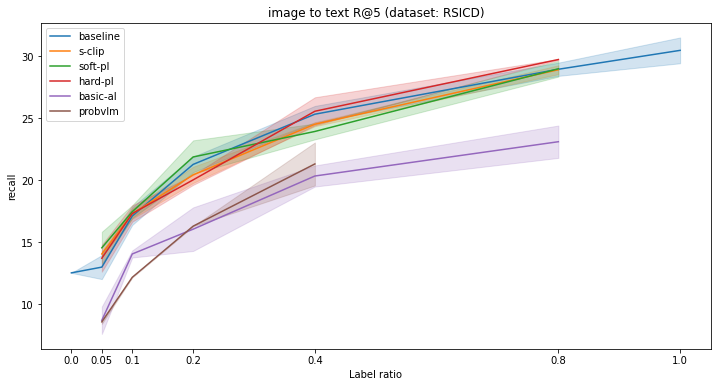

baseline image_to_text_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
18     0.00  None     UCM   base  image_to_text_R@5  64  0.00005       0.0   
192    0.05  None     UCM   base  image_to_text_R@5  64  0.00005      25.0   
2328   0.10  None     UCM   base  image_to_text_R@5  64  0.00005      25.0   
4464   0.20  None     UCM   base  image_to_text_R@5  64  0.00005      25.0   
6980   0.40  None     UCM   base  image_to_text_R@5  64  0.00005      25.0   
9541   0.80  None     UCM   base  image_to_text_R@5  64  0.00005      25.0   
12066  1.00  None     UCM   base  image_to_text_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
18         0     NaN   False  29.520  0.000000     2  
192       25     NaN   False  34.954  1.704444     5  
2328      25     NaN   False  39.810  3.220877     5  
4464      25     NaN   False  48.286  2.395074     5  
6980      25     NaN   False  52.000  2.412955     5  
9541      25     NaN   False  55.716  1.784637     5  
12066     25     NaN   False  58.384  1.562380     5

s-clip image_to_text_R@5 UCM


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1314   0.05  ot.image     UCM   ours  image_to_text_R@5  128  0.00005   
3450   0.10  ot.image     UCM   ours  image_to_text_R@5  128  0.00005   
5586   0.20  ot.image     UCM   ours  image_to_text_R@5  128  0.00005   
8202   0.40  ot.image     UCM   ours  image_to_text_R@5  128  0.00005   
10746  0.80  ot.image     UCM   ours  image_to_text_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1314       25.0     25     NaN   False  36.092  2.085454     5  
3450       25.0     25     NaN   False  42.478  0.854178     5  
5586       25.0     25     NaN   False  50.474  1.064368     5  
8202       25.0     25     NaN   False  49.052  2.128737     5  
10746      25.0     25     NaN   False  59.050  2.936614     5

pad end: 1
soft-pl image_to_text_R@5 UCM


ratio         PL dataset method             metric  bs       lr  \
                                                                        
2009   0.05  soft.text     UCM   ours  image_to_text_R@5  64  0.00005   
4145   0.10  soft.text     UCM   ours  image_to_text_R@5  64  0.00005   
6281   0.20  soft.text     UCM   ours  image_to_text_R@5  64  0.00005   
8897   0.40  soft.text     UCM   ours  image_to_text_R@5  64  0.00005   
11441  0.80  soft.text     UCM   ours  image_to_text_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
2009       30.0     30     NaN   False  37.334  1.737910     5  
4145       30.0     30     NaN   False  40.286  3.309151     5  
6281       30.0     30     NaN   False  47.240  2.743866     5  
8897       30.0     30     NaN   False  52.952  3.537438     5  
11441      30.0     30     NaN   False  55.428  1.043417     5

pad end: 1
hard-pl image_to_text_R@5 UCM


ratio         PL dataset method             metric  bs       lr  \
                                                                        
714    0.05  hard.text     UCM   ours  image_to_text_R@5  64  0.00005   
2850   0.10  hard.text     UCM   ours  image_to_text_R@5  64  0.00005   
4986   0.20  hard.text     UCM   ours  image_to_text_R@5  64  0.00005   
7602   0.40  hard.text     UCM   ours  image_to_text_R@5  64  0.00005   
10146  0.80  hard.text     UCM   ours  image_to_text_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
714        25.0     25     NaN   False  35.622  4.884902     5  
2850       25.0     25     NaN   False  42.760  1.915568     5  
4986       25.0     25     NaN   False  47.810  3.423543     5  
7602       25.0     25     NaN   False  54.666  3.020576     5  
10146      25.0     25     NaN   False  57.052  2.343399     5

pad end: 1
basic-al image_to_text_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
187   0.05  None     UCM   base  image_to_text_R@5  64  0.00005      10.0   
2323  0.10  None     UCM   base  image_to_text_R@5  64  0.00005      10.0   
4459  0.20  None     UCM   base  image_to_text_R@5  64  0.00005      10.0   
6955  0.40  None     UCM   base  image_to_text_R@5  64  0.00005      10.0   
9516  0.80  None     UCM   base  image_to_text_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
187      20     2.0   False  33.238  2.943802     5  
2323     20     5.0   False  36.192  4.795667     5  
4459     20    10.0   False  44.762  3.704918     5  
6955     20    20.0   False  49.240  1.040673     5  
9516     20    40.0   False  52.952  0.783243     5

pad end: 1
probvlm image_to_text_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
186   0.05  None     UCM   base  image_to_text_R@5  32  0.00005      10.0   
2322  0.10  None     UCM   base  image_to_text_R@5  32  0.00005      10.0   
4458  0.20  None     UCM   base  image_to_text_R@5  32  0.00005      10.0   
6954  0.40  None     UCM   base  image_to_text_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
186      25     2.0    True  29.812  1.493693     5  
2322     25     5.0    True  34.760  0.000000     5  
4458     25    10.0    True  43.330  0.000000     5  
6954     25    20.0    True  49.140  4.208943     5

pad end: 2


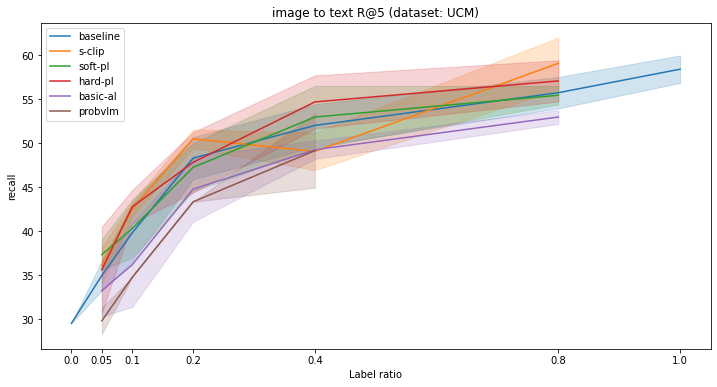

baseline image_to_text_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
12     0.00  None  Sydney   base  image_to_text_R@5  64  0.00005       0.0   
138    0.05  None  Sydney   base  image_to_text_R@5  64  0.00005      25.0   
2274   0.10  None  Sydney   base  image_to_text_R@5  64  0.00005      25.0   
4410   0.20  None  Sydney   base  image_to_text_R@5  64  0.00005      25.0   
6806   0.40  None  Sydney   base  image_to_text_R@5  64  0.00005      25.0   
9385   0.80  None  Sydney   base  image_to_text_R@5  64  0.00005      25.0   
11916  1.00  None  Sydney   base  image_to_text_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
12         0     NaN   False   7.040  0.000000     2  
138       25     NaN   False   9.498  1.629193     5  
2274      25     NaN   False  10.944  1.842099     5  
4410      25     NaN   False  15.454  1.396954     5  
6806      25     NaN   False  25.954  1.208338     5  
9385      25     NaN   False  39.274  1.375384     5  
11916     25     NaN   False  38.270  1.289981     5

s-clip image_to_text_R@5 Sydney


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1164   0.05  ot.image  Sydney   ours  image_to_text_R@5  128  0.00005   
3300   0.10  ot.image  Sydney   ours  image_to_text_R@5  128  0.00005   
5436   0.20  ot.image  Sydney   ours  image_to_text_R@5  128  0.00005   
8052   0.40  ot.image  Sydney   ours  image_to_text_R@5  128  0.00005   
10596  0.80  ot.image  Sydney   ours  image_to_text_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1164       25.0     25     NaN   False   9.940  0.862583     5  
3300       25.0     25     NaN   False  11.748  0.720014     5  
5436       25.0     25     NaN   False  13.120  0.089443     5  
8052       25.0     25     NaN   False  19.152  0.093915     5  
10596      25.0     25     NaN   False  31.268  1.657564     5

pad end: 1
soft-pl image_to_text_R@5 Sydney


ratio         PL dataset method             metric  bs       lr  \
                                                                        
1829   0.05  soft.text  Sydney   ours  image_to_text_R@5  64  0.00005   
3965   0.10  soft.text  Sydney   ours  image_to_text_R@5  64  0.00005   
6101   0.20  soft.text  Sydney   ours  image_to_text_R@5  64  0.00005   
8717   0.40  soft.text  Sydney   ours  image_to_text_R@5  64  0.00005   
11261  0.80  soft.text  Sydney   ours  image_to_text_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1829       30.0     30     NaN   False   9.294  0.846540     5  
3965       30.0     30     NaN   False  10.786  1.423808     5  
6101       30.0     30     NaN   False  14.526  0.929774     5  
8717       30.0     30     NaN   False  19.920  1.479223     5  
11261      30.0     30     NaN   False  27.928  1.676595     5

pad end: 1
hard-pl image_to_text_R@5 Sydney


ratio         PL dataset method             metric  bs       lr  \
                                                                       
564   0.05  hard.text  Sydney   ours  image_to_text_R@5  64  0.00005   
2700  0.10  hard.text  Sydney   ours  image_to_text_R@5  64  0.00005   
4836  0.20  hard.text  Sydney   ours  image_to_text_R@5  64  0.00005   
7452  0.40  hard.text  Sydney   ours  image_to_text_R@5  64  0.00005   
9996  0.80  hard.text  Sydney   ours  image_to_text_R@5  64  0.00005   

     AL.epochs epochs AL.iter ProbVLM   value                  
                                         mean       std count  
564       25.0     25     NaN   False   9.900  0.822830     5  
2700      25.0     25     NaN   False  11.548  1.408020     5  
4836      25.0     25     NaN   False  12.234  1.341801     5  
7452      25.0     25     NaN   False  18.390  1.413895     5  
9996      25.0     25     NaN   False  24.706  1.712828     5

pad end: 1
basic-al image_to_text_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
133   0.05  None  Sydney   base  image_to_text_R@5  64  0.00005      10.0   
2269  0.10  None  Sydney   base  image_to_text_R@5  64  0.00005      10.0   
4405  0.20  None  Sydney   base  image_to_text_R@5  64  0.00005      10.0   
6781  0.40  None  Sydney   base  image_to_text_R@5  64  0.00005      10.0   
9360  0.80  None  Sydney   base  image_to_text_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
133      20     2.0   False   6.638  1.357229     5  
2269     20     5.0   False  10.540  0.268328     5  
4405     20    10.0   False  14.370  4.299622     5  
6781     20    20.0   False  21.528  2.755044     5  
9360     20    40.0   False  31.872  0.996855     5

pad end: 1
probvlm image_to_text_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
132   0.05  None  Sydney   base  image_to_text_R@5  32  0.00005      10.0   
2268  0.10  None  Sydney   base  image_to_text_R@5  32  0.00005      10.0   
4404  0.20  None  Sydney   base  image_to_text_R@5  32  0.00005      10.0   
6780  0.40  None  Sydney   base  image_to_text_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
132      25     2.0    True   8.772  0.720014     5  
2268     25     5.0    True  11.070  0.000000     5  
4404     25    10.0    True  10.870  0.000000     5  
6780     25    20.0    True  15.088  0.791846     5

pad end: 2


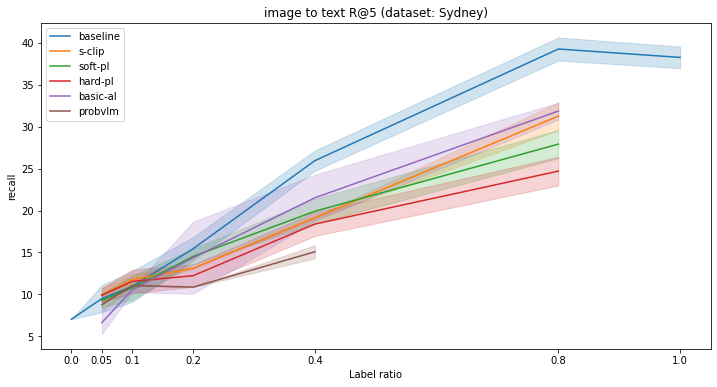

baseline text_to_image_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
7      0.00  None   RSICD   base  text_to_image_R@5  64  0.00005       0.0   
93     0.05  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
2229   0.10  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
4365   0.20  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
6661   0.40  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
9255   0.80  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
11791  1.00  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
7          0     NaN   False  14.270  0.000000     2  
93        25     NaN   False  13.122  0.420678     5  
2229      25     NaN   False  16.690  0.939920     5  
4365      25     NaN   False  20.806  1.018052     5  
6661      25     NaN   False  24.904  0.638968     5  
9255      25     NaN   False  29.532  0.979525     5  
11791     25     NaN   False  31.070  1.026913     5

s-clip text_to_image_R@5 RSICD


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1039   0.05  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   
3175   0.10  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   
5311   0.20  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   
7927   0.40  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   
10471  0.80  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1039       25.0     25     NaN   False  13.924  0.474847     5  
3175       25.0     25     NaN   False  17.196  0.818401     5  
5311       25.0     25     NaN   False  19.978  0.286217     5  
7927       25.0     25     NaN   False  23.462  0.898899     5  
10471      25.0     25     NaN   False  28.968  0.733430     5

pad end: 1
soft-pl text_to_image_R@5 RSICD


ratio         PL dataset method             metric  bs       lr  \
                                                                        
1679   0.05  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   
3815   0.10  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   
5951   0.20  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   
8567   0.40  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   
11111  0.80  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1679       30.0     30     NaN   False  14.638  0.614549     5  
3815       30.0     30     NaN   False  18.152  0.697653     5  
5951       30.0     30     NaN   False  22.234  1.206764     5  
8567       30.0     30     NaN   False  25.712  0.497112     5  
11111      30.0     30     NaN   False  30.062  1.053551     5

pad end: 1
hard-pl text_to_image_R@5 RSICD


ratio         PL dataset method             metric  bs       lr  \
                                                                       
439   0.05  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   
2575  0.10  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   
4711  0.20  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   
7327  0.40  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   
9871  0.80  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   

     AL.epochs epochs AL.iter ProbVLM   value                  
                                         mean       std count  
439       25.0     25     NaN   False  13.630  0.606795     5  
2575      25.0     25     NaN   False  17.988  1.053812     5  
4711      25.0     25     NaN   False  20.258  0.612021     5  
7327      25.0     25     NaN   False  25.616  0.849723     5  
9871      25.0     25     NaN   False  30.248  0.532184     5

pad end: 1
basic-al text_to_image_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
88    0.05  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   
2224  0.10  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   
4360  0.20  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   
6636  0.40  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   
9230  0.80  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
88       20     2.0   False   8.324  1.836608     5  
2224     20     5.0   False  12.422  0.075299     5  
4360     20    10.0   False  15.830  1.833548     5  
6636     20    20.0   False  20.806  1.456942     5  
9230     20    40.0   False  24.210  0.301247     5

pad end: 1
probvlm text_to_image_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
87    0.05  None   RSICD   base  text_to_image_R@5  32  0.00005      10.0   
2223  0.10  None   RSICD   base  text_to_image_R@5  32  0.00005      10.0   
4359  0.20  None   RSICD   base  text_to_image_R@5  32  0.00005      10.0   
6635  0.40  None   RSICD   base  text_to_image_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
87       25     2.0    True   7.760  0.245967     5  
2223     25     5.0    True  12.630  0.000000     5  
4359     25    10.0    True  17.020  0.000000     5  
6635     25    20.0    True  21.082  0.339588     5

pad end: 2


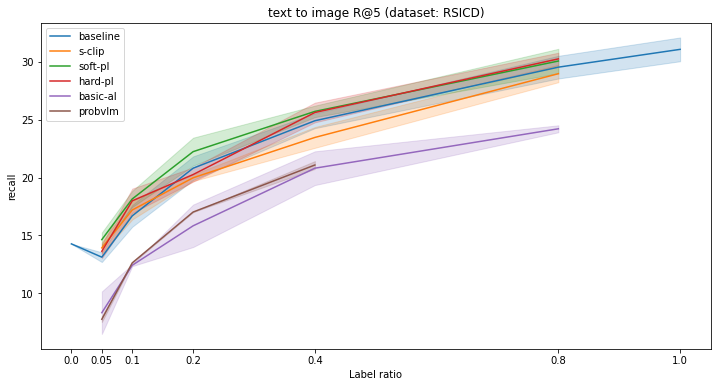

baseline text_to_image_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
21     0.00  None     UCM   base  text_to_image_R@5  64  0.00005       0.0   
219    0.05  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
2355   0.10  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
4491   0.20  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
7067   0.40  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
9619   0.80  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
12141  1.00  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
21         0     NaN   False  31.430  0.000000     2  
219       25     NaN   False  35.142  3.341118     5  
2355      25     NaN   False  38.096  1.814657     5  
4491      25     NaN   False  48.666  1.033697     5  
7067      25     NaN   False  50.666  1.735578     5  
9619      25     NaN   False  55.334  1.824179     5  
12141     25     NaN   False  59.714  2.558062     5

s-clip text_to_image_R@5 UCM


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1389   0.05  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   
3525   0.10  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   
5661   0.20  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   
8277   0.40  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   
10821  0.80  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1389       25.0     25     NaN   False  36.096  1.829393     5  
3525       25.0     25     NaN   False  43.140  0.424853     5  
5661       25.0     25     NaN   False  52.950  0.849706     5  
8277       25.0     25     NaN   False  51.900  0.000000     5  
10821      25.0     25     NaN   False  58.854  1.489221     5

pad end: 1
soft-pl text_to_image_R@5 UCM


ratio         PL dataset method             metric  bs       lr  \
                                                                        
2099   0.05  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   
4235   0.10  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   
6371   0.20  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   
8987   0.40  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   
11531  0.80  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
2099       30.0     30     NaN   False  38.192  3.292107     5  
4235       30.0     30     NaN   False  42.476  1.362289     5  
6371       30.0     30     NaN   False  46.474  0.926974     5  
8987       30.0     30     NaN   False  52.188  1.192841     5  
11531      30.0     30     NaN   False  57.618  1.431667     5

pad end: 1
hard-pl text_to_image_R@5 UCM


ratio         PL dataset method             metric  bs       lr  \
                                                                        
789    0.05  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   
2925   0.10  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   
5061   0.20  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   
7677   0.40  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   
10221  0.80  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
789        25.0     25     NaN   False  35.430  3.755210     5  
2925       25.0     25     NaN   False  43.906  3.390403     5  
5061       25.0     25     NaN   False  48.476  3.202246     5  
7677       25.0     25     NaN   False  53.998  3.096784     5  
10221      25.0     25     NaN   False  59.808  2.553590     5

pad end: 1
basic-al text_to_image_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
214   0.05  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   
2350  0.10  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   
4486  0.20  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   
7042  0.40  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   
9594  0.80  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
214      20     2.0   False  33.428  1.915690     5  
2350     20     5.0   False  39.046  1.064368     5  
4486     20    10.0   False  42.856  1.344388     5  
7042     20    20.0   False  48.666  3.127496     5  
9594     20    40.0   False  52.858  1.303580     5

pad end: 1
probvlm text_to_image_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
213   0.05  None     UCM   base  text_to_image_R@5  32  0.00005      10.0   
2349  0.10  None     UCM   base  text_to_image_R@5  32  0.00005      10.0   
4485  0.20  None     UCM   base  text_to_image_R@5  32  0.00005      10.0   
7041  0.40  None     UCM   base  text_to_image_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
213      25     2.0    True  29.242  2.768252     5  
2349     25     5.0    True  36.190  0.000000     5  
4485     25    10.0    True  42.380  0.000000     5  
7041     25    20.0    True  45.528  2.768252     5

pad end: 2


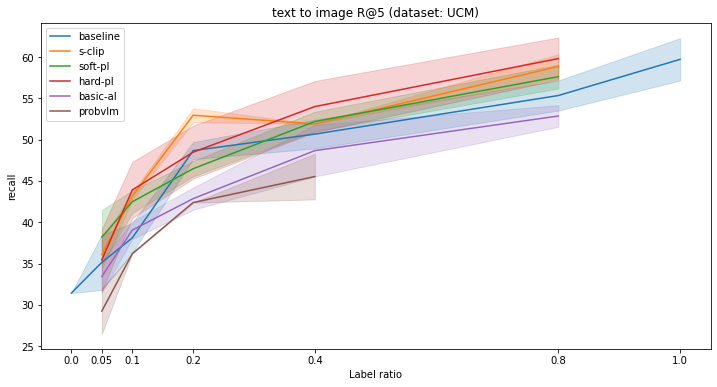

baseline text_to_image_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
15     0.00  None  Sydney   base  text_to_image_R@5  64  0.00005       0.0   
165    0.05  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
2301   0.10  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
4437   0.20  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
6893   0.40  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
9463   0.80  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
11991  1.00  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
15         0     NaN   False  10.660  0.000000     2  
165       25     NaN   False  10.746  0.677370     5  
2301      25     NaN   False  14.406  1.293940     5  
4437      25     NaN   False  18.350  2.141775     5  
6893      25     NaN   False  27.044  1.087764     5  
9463      25     NaN   False  36.578  1.041091     5  
11991     25     NaN   False  37.666  0.438668     5

s-clip text_to_image_R@5 Sydney


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1239   0.05  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   
3375   0.10  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   
5511   0.20  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   
8127   0.40  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   
10671  0.80  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1239       25.0     25     NaN   False   9.742  1.077785     5  
3375       25.0     25     NaN   False  14.568  0.720014     5  
5511       25.0     25     NaN   False  17.140  0.357771     5  
8127       25.0     25     NaN   False  22.014  1.529470     5  
10671      25.0     25     NaN   False  31.710  0.178885     5

pad end: 1
soft-pl text_to_image_R@5 Sydney


ratio         PL dataset method             metric  bs       lr  \
                                                                        
1919   0.05  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   
4055   0.10  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   
6191   0.20  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   
8807   0.40  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   
11351  0.80  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1919       30.0     30     NaN   False  11.146  2.197494     5  
4055       30.0     30     NaN   False  12.714  1.453850     5  
6191       30.0     30     NaN   False  17.382  0.719458     5  
8807       30.0     30     NaN   False  20.806  1.218536     5  
11351      30.0     30     NaN   False  27.848  0.442063     5

pad end: 1
hard-pl text_to_image_R@5 Sydney


ratio         PL dataset method             metric  bs       lr  \
                                                                        
639    0.05  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   
2775   0.10  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   
4911   0.20  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   
7527   0.40  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   
10071  0.80  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
639        25.0     25     NaN   False   9.656  0.752350     5  
2775       25.0     25     NaN   False  12.876  0.493994     5  
4911       25.0     25     NaN   False  16.016  0.848664     5  
7527       25.0     25     NaN   False  21.328  1.865508     5  
10071      25.0     25     NaN   False  26.200  0.089443     5

pad end: 1
basic-al text_to_image_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
160   0.05  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   
2296  0.10  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   
4432  0.20  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   
6868  0.40  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   
9438  0.80  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
160      20     2.0   False   8.250  0.648074     5  
2296     20     5.0   False  10.464  1.797799     5  
4432     20    10.0   False  16.096  4.025001     5  
6868     20    20.0   False  21.324  3.855967     5  
9438     20    40.0   False  33.122  1.763667     5

pad end: 1
probvlm text_to_image_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
159   0.05  None  Sydney   base  text_to_image_R@5  32  0.00005      10.0   
2295  0.10  None  Sydney   base  text_to_image_R@5  32  0.00005      10.0   
4431  0.20  None  Sydney   base  text_to_image_R@5  32  0.00005      10.0   
6867  0.40  None  Sydney   base  text_to_image_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
159      25     2.0    True   8.810  0.089443     5  
2295     25     5.0    True  13.480  0.000000     5  
4431     25    10.0    True  12.680  0.000000     5  
6867     25    20.0    True  15.978  0.718624     5

pad end: 2


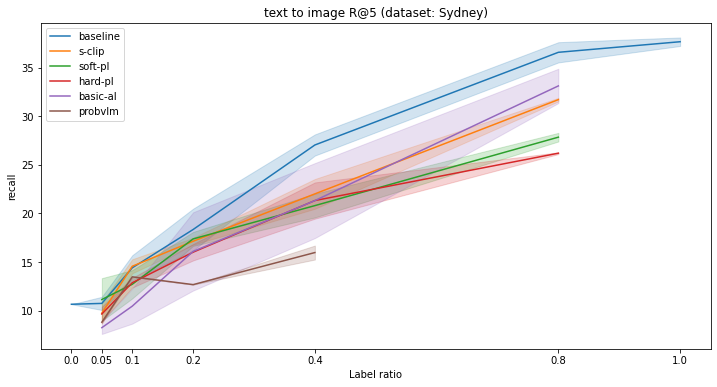

In [19]:
metrics = ['image_to_text_R@5', 'text_to_image_R@5']
datasets = ['RSICD', 'UCM', 'Sydney']
for metric in metrics:
    for dataset in datasets:
        plot_model_comparison(results_dict, metric, dataset)

RSICD-CLS zeroshot-val-top1
baseline zeroshot-val-top1 RSICD-CLS


ratio    PL    dataset method             metric  bs       lr AL.epochs  \
                                                                                
8      0.00  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005       0.0   
102    0.05  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
2238   0.10  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
4374   0.20  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
6690   0.40  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
9281   0.80  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
11816  1.00  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
8          0     NaN   False  53.710  0.000000     3  
102       25     NaN   False  56.652  1.917008     5  
2238      25     NaN   False  63.916  1.673090     5  
4374      25     NaN   False  72.700  1.399071     5  
6690      25     NaN   False  83.220  1.070047     5  
9281      25     NaN   False  84.592  2.209835     5  
11816     25     NaN   False  85.142  1.542359     5

s-clip zeroshot-val-top1 RSICD-CLS


ratio        PL    dataset method             metric   bs       lr  \
                                                                           
1064   0.05  ot.image  RSICD-CLS   ours  zeroshot-val-top1  128  0.00005   
3200   0.10  ot.image  RSICD-CLS   ours  zeroshot-val-top1  128  0.00005   
5336   0.20  ot.image  RSICD-CLS   ours  zeroshot-val-top1  128  0.00005   
7952   0.40  ot.image  RSICD-CLS   ours  zeroshot-val-top1  128  0.00005   
10496  0.80  ot.image  RSICD-CLS   ours  zeroshot-val-top1  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1064       25.0     25     NaN   False  55.884  1.488247     5  
3200       25.0     25     NaN   False  64.828  2.128737     5  
5336       25.0     25     NaN   False  77.950  1.229837     5  
7952       25.0     25     NaN   False  85.580  0.939149     5  
10496      25.0     25     NaN   False  86.732  1.024119     5

pad end: 1
soft-pl zeroshot-val-top1 RSICD-CLS


ratio         PL    dataset method             metric  bs       lr  \
                                                                           
1709   0.05  soft.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   
3845   0.10  soft.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   
5981   0.20  soft.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   
8597   0.40  soft.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   
11141  0.80  soft.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1709       30.0     30     NaN   False  57.108  1.777645     5  
3845       30.0     30     NaN   False  63.640  0.868188     5  
5981       30.0     30     NaN   False  77.016  1.222448     5  
8597       30.0     30     NaN   False  83.168  2.388874     5  
11141      30.0     30     NaN   False  88.748  0.948061     5

pad end: 1
hard-pl zeroshot-val-top1 RSICD-CLS


ratio         PL    dataset method             metric  bs       lr  \
                                                                          
464   0.05  hard.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   
2600  0.10  hard.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   
4736  0.20  hard.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   
7352  0.40  hard.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   
9896  0.80  hard.text  RSICD-CLS   ours  zeroshot-val-top1  64  0.00005   

     AL.epochs epochs AL.iter ProbVLM   value                  
                                         mean       std count  
464       25.0     25     NaN   False  59.012  1.691204     5  
2600      25.0     25     NaN   False  65.214  2.675253     5  
4736      25.0     25     NaN   False  75.314  0.452526     5  
7352      25.0     25     NaN   False  82.086  2.044170     5  
9896      25.0     25     NaN   False  84.888  0.979398     5

pad end: 1
basic-al zeroshot-val-top1 RSICD-CLS


ratio    PL    dataset method             metric  bs       lr AL.epochs  \
                                                                               
97    0.05  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      10.0   
2233  0.10  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      10.0   
4369  0.20  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      10.0   
6665  0.40  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      10.0   
9256  0.80  None  RSICD-CLS   base  zeroshot-val-top1  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
97       20     2.0   False  42.434  2.685280     5  
2233     20     5.0   False  57.002  3.735555     5  
4369     20    10.0   False  62.452  7.301234     5  
6665     20    20.0   False  71.418  3.708082     5  
9256     20    40.0   False  78.776  1.500760     5

pad end: 1
probvlm zeroshot-val-top1 RSICD-CLS


ratio    PL    dataset method             metric  bs       lr AL.epochs  \
                                                                               
96    0.05  None  RSICD-CLS   base  zeroshot-val-top1  32  0.00005      10.0   
2232  0.10  None  RSICD-CLS   base  zeroshot-val-top1  32  0.00005      10.0   
4368  0.20  None  RSICD-CLS   base  zeroshot-val-top1  32  0.00005      10.0   
6664  0.40  None  RSICD-CLS   base  zeroshot-val-top1  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
96       25     2.0    True  38.460  0.290689     5  
2232     25     5.0    True  53.610  0.000000     5  
4368     25    10.0    True  61.480  0.000000     5  
6664     25    20.0    True  73.832  5.242053     5

pad end: 2


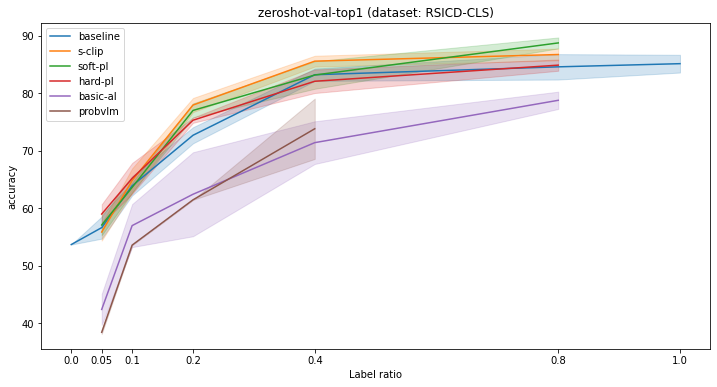

UCM-CLS zeroshot-val-top1
baseline zeroshot-val-top1 UCM-CLS


ratio    PL  dataset method             metric  bs       lr AL.epochs  \
                                                                              
22     0.00  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005       0.0   
228    0.05  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
2364   0.10  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
4500   0.20  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
7096   0.40  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
9645   0.80  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      25.0   
12166  1.00  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                      
                                mean           std count  
22         0     NaN   False  49.050  8.702336e-15     3  
228       25     NaN   False  53.332  2.104904e+00     5  
2364      25     NaN   False  57.712  1.974062e+00     5  
4500      25     NaN   False  68.476  1.361591e+00     5  
7096      25     NaN   False  71.238  2.924691e+00     5  
9645      25     NaN   False  76.284  1.827438e+00     5  
12166     25     NaN   False  68.666  3.150775e+00     5

s-clip zeroshot-val-top1 UCM-CLS


ratio        PL  dataset method             metric   bs       lr  \
                                                                         
1414   0.05  ot.image  UCM-CLS   ours  zeroshot-val-top1  128  0.00005   
3550   0.10  ot.image  UCM-CLS   ours  zeroshot-val-top1  128  0.00005   
5686   0.20  ot.image  UCM-CLS   ours  zeroshot-val-top1  128  0.00005   
8302   0.40  ot.image  UCM-CLS   ours  zeroshot-val-top1  128  0.00005   
10846  0.80  ot.image  UCM-CLS   ours  zeroshot-val-top1  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1414       25.0     25     NaN   False  57.904  1.046150     5  
3550       25.0     25     NaN   False  63.618  1.192841     5  
5686       25.0     25     NaN   False  70.384  0.214663     5  
8302       25.0     25     NaN   False  68.760  0.424853     5  
10846      25.0     25     NaN   False  73.426  0.214663     5

pad end: 1
soft-pl zeroshot-val-top1 UCM-CLS


ratio         PL  dataset method             metric  bs       lr  \
                                                                         
2129   0.05  soft.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   
4265   0.10  soft.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   
6401   0.20  soft.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   
9017   0.40  soft.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   
11561  0.80  soft.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
2129       30.0     30     NaN   False  53.812  2.104904     5  
4265       30.0     30     NaN   False  62.762  3.523283     5  
6401       30.0     30     NaN   False  71.716  0.639515     5  
9017       30.0     30     NaN   False  73.142  0.986671     5  
11561      30.0     30     NaN   False  73.618  2.170500     5

pad end: 1
hard-pl zeroshot-val-top1 UCM-CLS


ratio         PL  dataset method             metric  bs       lr  \
                                                                         
814    0.05  hard.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   
2950   0.10  hard.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   
5086   0.20  hard.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   
7702   0.40  hard.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   
10246  0.80  hard.text  UCM-CLS   ours  zeroshot-val-top1  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
814        25.0     25     NaN   False  51.618  5.267326     5  
2950       25.0     25     NaN   False  62.948  2.702086     5  
5086       25.0     25     NaN   False  67.906  2.513102     5  
7702       25.0     25     NaN   False  73.904  3.707024     5  
10246      25.0     25     NaN   False  69.716  1.489221     5

pad end: 1
basic-al zeroshot-val-top1 UCM-CLS


ratio    PL  dataset method             metric  bs       lr AL.epochs  \
                                                                             
223   0.05  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      10.0   
2359  0.10  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      10.0   
4495  0.20  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      10.0   
7071  0.40  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      10.0   
9620  0.80  None  UCM-CLS   base  zeroshot-val-top1  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
223      20     2.0   False  54.952  3.381016     5  
2359     20     5.0   False  55.906  4.686798     5  
4495     20    10.0   False  63.806  1.782633     5  
7071     20    20.0   False  65.998  3.653309     5  
9620     20    40.0   False  72.188  3.653309     5

pad end: 1
probvlm zeroshot-val-top1 UCM-CLS


ratio    PL  dataset method             metric  bs       lr AL.epochs  \
                                                                             
222   0.05  None  UCM-CLS   base  zeroshot-val-top1  32  0.00005      10.0   
2358  0.10  None  UCM-CLS   base  zeroshot-val-top1  32  0.00005      10.0   
4494  0.20  None  UCM-CLS   base  zeroshot-val-top1  32  0.00005      10.0   
7070  0.40  None  UCM-CLS   base  zeroshot-val-top1  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                      
                               mean           std count  
222      25     2.0    True  43.332  3.193105e+00     5  
2358     25     5.0    True  52.860  0.000000e+00     5  
4494     25    10.0    True  58.570  7.944109e-15     5  
7070     25    20.0    True  67.240  6.203128e+00     5

pad end: 2


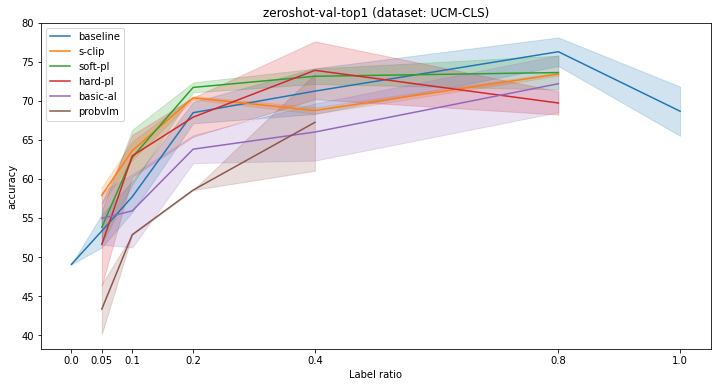

WHU-RS19 zeroshot-val-top1
baseline zeroshot-val-top1 WHU-RS19


ratio    PL   dataset method             metric  bs       lr AL.epochs  \
                                                                               
23     0.00  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005       0.0   
237    0.05  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      25.0   
2373   0.10  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      25.0   
4509   0.20  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      25.0   
7125   0.40  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      25.0   
9671   0.80  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      25.0   
12191  1.00  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
23         0     NaN   False  68.560  0.000000     3  
237       25     NaN   False  72.816  2.298027     5  
2373      25     NaN   False  81.810  1.640290     5  
4509      25     NaN   False  86.944  2.460961     5  
7125      25     NaN   False  93.252  0.540759     5  
9671      25     NaN   False  94.926  0.692120     5  
12191     25     NaN   False  93.032  0.500520     5

s-clip zeroshot-val-top1 WHU-RS19


ratio        PL   dataset method             metric   bs       lr  \
                                                                          
1439   0.05  ot.image  WHU-RS19   ours  zeroshot-val-top1  128  0.00005   
3575   0.10  ot.image  WHU-RS19   ours  zeroshot-val-top1  128  0.00005   
5711   0.20  ot.image  WHU-RS19   ours  zeroshot-val-top1  128  0.00005   
8327   0.40  ot.image  WHU-RS19   ours  zeroshot-val-top1  128  0.00005   
10871  0.80  ot.image  WHU-RS19   ours  zeroshot-val-top1  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1439       25.0     25     NaN   False  76.776  1.231109     5  
3575       25.0     25     NaN   False  84.932  0.979398     5  
5711       25.0     25     NaN   False  87.784  2.714587     5  
8327       25.0     25     NaN   False  95.780  0.134164     5  
10871      25.0     25     NaN   False  96.678  0.353299     5

pad end: 1
soft-pl zeroshot-val-top1 WHU-RS19


ratio         PL   dataset method             metric  bs       lr  \
                                                                          
2159   0.05  soft.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   
4295   0.10  soft.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   
6431   0.20  soft.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   
9047   0.40  soft.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   
11591  0.80  soft.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
2159       30.0     30     NaN   False  77.570  1.490822     5  
4295       30.0     30     NaN   False  83.282  3.577467     5  
6431       30.0     30     NaN   False  91.882  1.660548     5  
9047       30.0     30     NaN   False  95.680  0.313050     5  
11591      30.0     30     NaN   False  96.734  0.760809     5

pad end: 1
hard-pl zeroshot-val-top1 WHU-RS19


ratio         PL   dataset method             metric  bs       lr  \
                                                                          
839    0.05  hard.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   
2975   0.10  hard.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   
5111   0.20  hard.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   
7727   0.40  hard.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   
10271  0.80  hard.text  WHU-RS19   ours  zeroshot-val-top1  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
839        25.0     25     NaN   False  76.616  3.076244     5  
2975       25.0     25     NaN   False  84.160  1.241813     5  
5111       25.0     25     NaN   False  91.182  1.490107     5  
7727       25.0     25     NaN   False  93.534  0.952119     5  
10271      25.0     25     NaN   False  97.134  1.287975     5

pad end: 1
basic-al zeroshot-val-top1 WHU-RS19


ratio    PL   dataset method             metric  bs       lr AL.epochs  \
                                                                              
232   0.05  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      10.0   
2368  0.10  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      10.0   
4504  0.20  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      10.0   
7100  0.40  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      10.0   
9646  0.80  None  WHU-RS19   base  zeroshot-val-top1  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
232      20     2.0   False  57.352  4.002408     5  
2368     20     5.0   False  70.686  2.133209     5  
4504     20    10.0   False  79.364  3.575735     5  
7100     20    20.0   False  84.456  0.925651     5  
9646     20    40.0   False  88.776  1.254285     5

pad end: 1
probvlm zeroshot-val-top1 WHU-RS19


ratio    PL   dataset method             metric  bs       lr AL.epochs  \
                                                                              
231   0.05  None  WHU-RS19   base  zeroshot-val-top1  32  0.00005      10.0   
2367  0.10  None  WHU-RS19   base  zeroshot-val-top1  32  0.00005      10.0   
4503  0.20  None  WHU-RS19   base  zeroshot-val-top1  32  0.00005      10.0   
7099  0.40  None  WHU-RS19   base  zeroshot-val-top1  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
231      25     2.0    True  55.426  3.340686     5  
2367     25     5.0    True  68.160  0.000000     5  
4503     25    10.0    True  74.430  0.000000     5  
7099     25    20.0    True  88.140  3.664451     5

pad end: 2


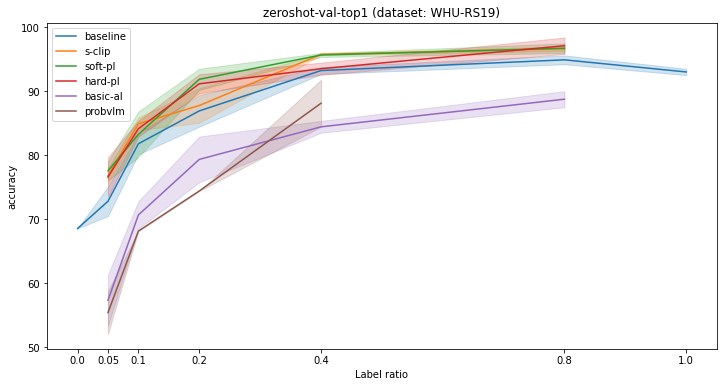

RSSCN7 zeroshot-val-top1
baseline zeroshot-val-top1 RSSCN7


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
9      0.00  None  RSSCN7   base  zeroshot-val-top1  64  0.00005       0.0   
111    0.05  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      25.0   
2247   0.10  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      25.0   
4383   0.20  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      25.0   
6719   0.40  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      25.0   
9307   0.80  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      25.0   
11841  1.00  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
9          0     NaN   False  55.000  0.000000     3  
111       25     NaN   False  54.836  1.017561     5  
2247      25     NaN   False  63.492  3.774284     5  
4383      25     NaN   False  65.036  1.538597     5  
6719      25     NaN   False  64.236  2.246526     5  
9307      25     NaN   False  66.378  3.602835     5  
11841     25     NaN   False  66.872  1.670500     5

s-clip zeroshot-val-top1 RSSCN7


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1089   0.05  ot.image  RSSCN7   ours  zeroshot-val-top1  128  0.00005   
3225   0.10  ot.image  RSSCN7   ours  zeroshot-val-top1  128  0.00005   
5361   0.20  ot.image  RSSCN7   ours  zeroshot-val-top1  128  0.00005   
7977   0.40  ot.image  RSSCN7   ours  zeroshot-val-top1  128  0.00005   
10521  0.80  ot.image  RSSCN7   ours  zeroshot-val-top1  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1089       25.0     25     NaN   False  57.146  3.059490     5  
3225       25.0     25     NaN   False  59.454  0.143108     5  
5361       25.0     25     NaN   False  66.004  3.049997     5  
7977       25.0     25     NaN   False  59.682  2.173458     5  
10521      25.0     25     NaN   False  66.902  0.465102     5

pad end: 1
soft-pl zeroshot-val-top1 RSSCN7


ratio         PL dataset method             metric  bs       lr  \
                                                                        
1739   0.05  soft.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   
3875   0.10  soft.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   
6011   0.20  soft.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   
8627   0.40  soft.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   
11171  0.80  soft.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1739       30.0     30     NaN   False  58.644  4.783020     5  
3875       30.0     30     NaN   False  62.436  1.606200     5  
6011       30.0     30     NaN   False  65.830  2.353657     5  
8627       30.0     30     NaN   False  67.864  1.889704     5  
11171      30.0     30     NaN   False  64.800  2.345666     5

pad end: 1
hard-pl zeroshot-val-top1 RSSCN7


ratio         PL dataset method             metric  bs       lr  \
                                                                       
489   0.05  hard.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   
2625  0.10  hard.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   
4761  0.20  hard.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   
7377  0.40  hard.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   
9921  0.80  hard.text  RSSCN7   ours  zeroshot-val-top1  64  0.00005   

     AL.epochs epochs AL.iter ProbVLM   value                  
                                         mean       std count  
489       25.0     25     NaN   False  56.786  3.571733     5  
2625      25.0     25     NaN   False  58.944  1.496489     5  
4761      25.0     25     NaN   False  64.956  3.422306     5  
7377      25.0     25     NaN   False  66.790  1.980795     5  
9921      25.0     25     NaN   False  64.002  0.720014     5

pad end: 1
basic-al zeroshot-val-top1 RSSCN7


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
106   0.05  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      10.0   
2242  0.10  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      10.0   
4378  0.20  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      10.0   
6694  0.40  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      10.0   
9282  0.80  None  RSSCN7   base  zeroshot-val-top1  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
106      20     2.0   False  51.362  1.423032     5  
2242     20     5.0   False  62.174  2.590652     5  
4378     20    10.0   False  61.194  2.826974     5  
6694     20    20.0   False  57.972  1.330966     5  
9282     20    40.0   False  60.122  3.247995     5

pad end: 1
probvlm zeroshot-val-top1 RSSCN7


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
105   0.05  None  RSSCN7   base  zeroshot-val-top1  32  0.00005      10.0   
2241  0.10  None  RSSCN7   base  zeroshot-val-top1  32  0.00005      10.0   
4377  0.20  None  RSSCN7   base  zeroshot-val-top1  32  0.00005      10.0   
6693  0.40  None  RSSCN7   base  zeroshot-val-top1  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
105      25     2.0    True  44.728  2.186874     5  
2241     25     5.0    True  53.000  0.000000     5  
4377     25    10.0    True  58.640  0.000000     5  
6693     25    20.0    True  56.884  1.110892     5

pad end: 2


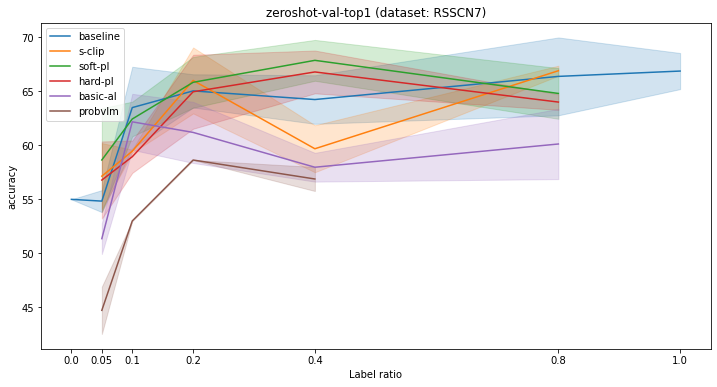

AID zeroshot-val-top1
baseline zeroshot-val-top1 AID


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
0      0.00  None     AID   base  zeroshot-val-top1  64  0.00005       0.0   
30     0.05  None     AID   base  zeroshot-val-top1  64  0.00005      25.0   
2166   0.10  None     AID   base  zeroshot-val-top1  64  0.00005      25.0   
4302   0.20  None     AID   base  zeroshot-val-top1  64  0.00005      25.0   
6458   0.40  None     AID   base  zeroshot-val-top1  64  0.00005      25.0   
9073   0.80  None     AID   base  zeroshot-val-top1  64  0.00005      25.0   
11616  1.00  None     AID   base  zeroshot-val-top1  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
0          0     NaN   False  52.820  0.000000     2  
30        25     NaN   False  61.106  2.422329     5  
2166      25     NaN   False  68.166  1.051038     5  
4302      25     NaN   False  77.632  1.239706     5  
6458      25     NaN   False  86.402  1.271739     5  
9073      25     NaN   False  89.808  0.570500     5  
11616     25     NaN   False  87.698  2.225774     5

s-clip zeroshot-val-top1 AID


ratio        PL dataset method             metric   bs       lr  \
                                                                        
864    0.05  ot.image     AID   ours  zeroshot-val-top1  128  0.00005   
3000   0.10  ot.image     AID   ours  zeroshot-val-top1  128  0.00005   
5136   0.20  ot.image     AID   ours  zeroshot-val-top1  128  0.00005   
7752   0.40  ot.image     AID   ours  zeroshot-val-top1  128  0.00005   
10296  0.80  ot.image     AID   ours  zeroshot-val-top1  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
864        25.0     25     NaN   False  60.780  1.260674     5  
3000       25.0     25     NaN   False  71.688  0.764735     5  
5136       25.0     25     NaN   False  81.980  0.201246     5  
7752       25.0     25     NaN   False  90.080  0.916788     5  
10296      25.0     25     NaN   False  91.262  0.152053     5

pad end: 1
soft-pl zeroshot-val-top1 AID


ratio         PL dataset method             metric  bs       lr  \
                                                                        
1469   0.05  soft.text     AID   ours  zeroshot-val-top1  64  0.00005   
3605   0.10  soft.text     AID   ours  zeroshot-val-top1  64  0.00005   
5741   0.20  soft.text     AID   ours  zeroshot-val-top1  64  0.00005   
8357   0.40  soft.text     AID   ours  zeroshot-val-top1  64  0.00005   
10901  0.80  soft.text     AID   ours  zeroshot-val-top1  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1469       30.0     30     NaN   False  61.662  1.410805     5  
3605       30.0     30     NaN   False  71.476  1.230114     5  
5741       30.0     30     NaN   False  83.206  0.878282     5  
8357       30.0     30     NaN   False  88.418  1.586591     5  
10901      30.0     30     NaN   False  92.858  0.868372     5

pad end: 1
hard-pl zeroshot-val-top1 AID


ratio         PL dataset method             metric  bs       lr  \
                                                                       
264   0.05  hard.text     AID   ours  zeroshot-val-top1  64  0.00005   
2400  0.10  hard.text     AID   ours  zeroshot-val-top1  64  0.00005   
4536  0.20  hard.text     AID   ours  zeroshot-val-top1  64  0.00005   
7152  0.40  hard.text     AID   ours  zeroshot-val-top1  64  0.00005   
9696  0.80  hard.text     AID   ours  zeroshot-val-top1  64  0.00005   

     AL.epochs epochs AL.iter ProbVLM   value                  
                                         mean       std count  
264       25.0     25     NaN   False  62.148  1.000335     5  
2400      25.0     25     NaN   False  71.790  0.514296     5  
4536      25.0     25     NaN   False  81.180  0.213307     5  
7152      25.0     25     NaN   False  87.206  1.901534     5  
9696      25.0     25     NaN   False  90.238  0.787096     5

pad end: 1
basic-al zeroshot-val-top1 AID


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
25    0.05  None     AID   base  zeroshot-val-top1  64  0.00005      10.0   
2161  0.10  None     AID   base  zeroshot-val-top1  64  0.00005      10.0   
4297  0.20  None     AID   base  zeroshot-val-top1  64  0.00005      10.0   
6433  0.40  None     AID   base  zeroshot-val-top1  64  0.00005      10.0   
9048  0.80  None     AID   base  zeroshot-val-top1  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
25       20     2.0   False  41.808  3.546022     5  
2161     20     5.0   False  58.554  4.111032     5  
4297     20    10.0   False  65.626  5.568454     5  
6433     20    20.0   False  75.212  5.137638     5  
9048     20    40.0   False  81.850  1.177603     5

pad end: 1
probvlm zeroshot-val-top1 AID


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
24    0.05  None     AID   base  zeroshot-val-top1  32  0.00005      10.0   
2160  0.10  None     AID   base  zeroshot-val-top1  32  0.00005      10.0   
4296  0.20  None     AID   base  zeroshot-val-top1  32  0.00005      10.0   
6432  0.40  None     AID   base  zeroshot-val-top1  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
24       25     2.0    True  40.574  2.294206     5  
2160     25     5.0    True  57.000  0.000000     5  
4296     25    10.0    True  66.170  0.000000     5  
6432     25    20.0    True  77.952  4.788661     5

pad end: 2


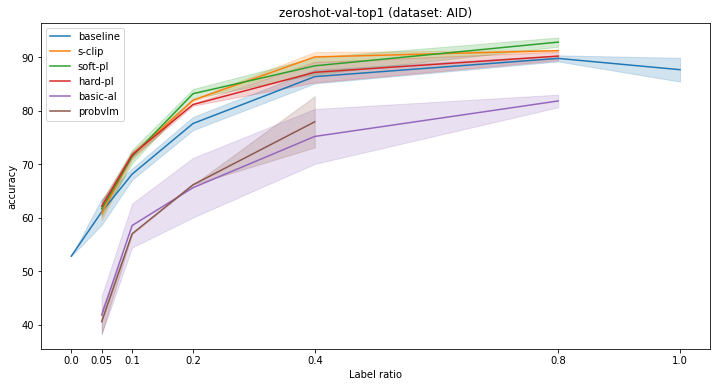

RESISC45 zeroshot-val-top1
baseline zeroshot-val-top1 RESISC45


ratio    PL   dataset method             metric  bs       lr AL.epochs  \
                                                                               
1      0.00  None  RESISC45   base  zeroshot-val-top1  64  0.00005       0.0   
39     0.05  None  RESISC45   base  zeroshot-val-top1  64  0.00005      25.0   
2175   0.10  None  RESISC45   base  zeroshot-val-top1  64  0.00005      25.0   
4311   0.20  None  RESISC45   base  zeroshot-val-top1  64  0.00005      25.0   
6487   0.40  None  RESISC45   base  zeroshot-val-top1  64  0.00005      25.0   
9099   0.80  None  RESISC45   base  zeroshot-val-top1  64  0.00005      25.0   
11641  1.00  None  RESISC45   base  zeroshot-val-top1  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
1          0     NaN   False  48.710  0.000000     2  
39        25     NaN   False  31.408  1.490493     5  
2175      25     NaN   False  32.692  1.019348     5  
4311      25     NaN   False  38.208  1.053931     5  
6487      25     NaN   False  40.236  1.704503     5  
9099      25     NaN   False  43.876  1.197969     5  
11641     25     NaN   False  45.844  0.564385     5

s-clip zeroshot-val-top1 RESISC45


ratio        PL   dataset method             metric   bs       lr  \
                                                                          
889    0.05  ot.image  RESISC45   ours  zeroshot-val-top1  128  0.00005   
3025   0.10  ot.image  RESISC45   ours  zeroshot-val-top1  128  0.00005   
5161   0.20  ot.image  RESISC45   ours  zeroshot-val-top1  128  0.00005   
7777   0.40  ot.image  RESISC45   ours  zeroshot-val-top1  128  0.00005   
10321  0.80  ot.image  RESISC45   ours  zeroshot-val-top1  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
889        25.0     25     NaN   False  31.670  0.645794     5  
3025       25.0     25     NaN   False  35.382  0.643988     5  
5161       25.0     25     NaN   False  42.808  1.748605     5  
7777       25.0     25     NaN   False  46.538  0.040249     5  
10321      25.0     25     NaN   False  49.022  1.957682     5

pad end: 1
soft-pl zeroshot-val-top1 RESISC45


ratio         PL   dataset method             metric  bs       lr  \
                                                                          
1499   0.05  soft.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   
3635   0.10  soft.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   
5771   0.20  soft.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   
8387   0.40  soft.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   
10931  0.80  soft.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1499       30.0     30     NaN   False  30.328  1.330233     5  
3635       30.0     30     NaN   False  36.942  2.449514     5  
5771       30.0     30     NaN   False  44.372  1.224978     5  
8387       30.0     30     NaN   False  45.820  1.336095     5  
10931      30.0     30     NaN   False  46.714  2.242338     5

pad end: 1
hard-pl zeroshot-val-top1 RESISC45


ratio         PL   dataset method             metric  bs       lr  \
                                                                         
289   0.05  hard.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   
2425  0.10  hard.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   
4561  0.20  hard.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   
7177  0.40  hard.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   
9721  0.80  hard.text  RESISC45   ours  zeroshot-val-top1  64  0.00005   

     AL.epochs epochs AL.iter ProbVLM   value                  
                                         mean       std count  
289       25.0     25     NaN   False  29.532  1.536219     5  
2425      25.0     25     NaN   False  35.312  0.492818     5  
4561      25.0     25     NaN   False  40.044  1.627108     5  
7177      25.0     25     NaN   False  44.900  1.230406     5  
9721      25.0     25     NaN   False  45.998  0.375659     5

pad end: 1
basic-al zeroshot-val-top1 RESISC45


ratio    PL   dataset method             metric  bs       lr AL.epochs  \
                                                                              
34    0.05  None  RESISC45   base  zeroshot-val-top1  64  0.00005      10.0   
2170  0.10  None  RESISC45   base  zeroshot-val-top1  64  0.00005      10.0   
4306  0.20  None  RESISC45   base  zeroshot-val-top1  64  0.00005      10.0   
6462  0.40  None  RESISC45   base  zeroshot-val-top1  64  0.00005      10.0   
9074  0.80  None  RESISC45   base  zeroshot-val-top1  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
34       20     2.0   False  22.062  2.054062     5  
2170     20     5.0   False  28.878  0.493072     5  
4306     20    10.0   False  32.034  3.995263     5  
6462     20    20.0   False  36.426  2.322344     5  
9074     20    40.0   False  39.226  0.432701     5

pad end: 1
probvlm zeroshot-val-top1 RESISC45


ratio    PL   dataset method             metric  bs       lr AL.epochs  \
                                                                              
33    0.05  None  RESISC45   base  zeroshot-val-top1  32  0.00005      10.0   
2169  0.10  None  RESISC45   base  zeroshot-val-top1  32  0.00005      10.0   
4305  0.20  None  RESISC45   base  zeroshot-val-top1  32  0.00005      10.0   
6461  0.40  None  RESISC45   base  zeroshot-val-top1  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                      
                               mean           std count  
33       25     2.0    True  21.322  2.504396e-01     5  
2169     25     5.0    True  27.030  0.000000e+00     5  
4305     25    10.0    True  27.190  3.972055e-15     5  
6461     25    20.0    True  33.748  2.435061e+00     5

pad end: 2


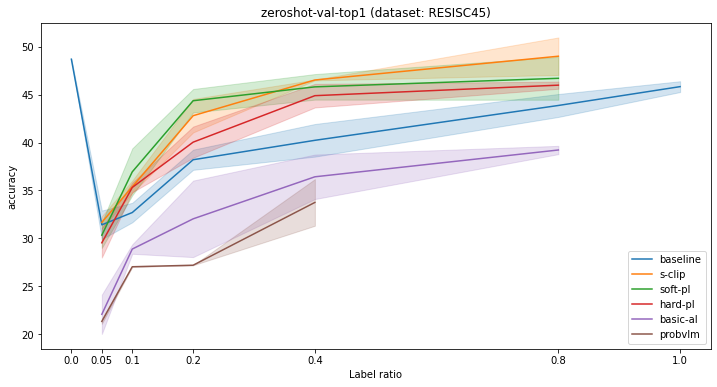

In [20]:
metric = 'zeroshot-val-top1'
datasets = ["RSICD-CLS", "UCM-CLS", "WHU-RS19", "RSSCN7", "AID", "RESISC45"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

baseline text_to_image_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
7      0.00  None   RSICD   base  text_to_image_R@5  64  0.00005       0.0   
93     0.05  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
2229   0.10  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
4365   0.20  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
6661   0.40  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
9255   0.80  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   
11791  1.00  None   RSICD   base  text_to_image_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
7          0     NaN   False  14.270  0.000000     2  
93        25     NaN   False  13.122  0.420678     5  
2229      25     NaN   False  16.690  0.939920     5  
4365      25     NaN   False  20.806  1.018052     5  
6661      25     NaN   False  24.904  0.638968     5  
9255      25     NaN   False  29.532  0.979525     5  
11791     25     NaN   False  31.070  1.026913     5

s-clip text_to_image_R@5 RSICD


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1039   0.05  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   
3175   0.10  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   
5311   0.20  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   
7927   0.40  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   
10471  0.80  ot.image   RSICD   ours  text_to_image_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1039       25.0     25     NaN   False  13.924  0.474847     5  
3175       25.0     25     NaN   False  17.196  0.818401     5  
5311       25.0     25     NaN   False  19.978  0.286217     5  
7927       25.0     25     NaN   False  23.462  0.898899     5  
10471      25.0     25     NaN   False  28.968  0.733430     5

pad end: 1
soft-pl text_to_image_R@5 RSICD


ratio         PL dataset method             metric  bs       lr  \
                                                                        
1679   0.05  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   
3815   0.10  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   
5951   0.20  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   
8567   0.40  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   
11111  0.80  soft.text   RSICD   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1679       30.0     30     NaN   False  14.638  0.614549     5  
3815       30.0     30     NaN   False  18.152  0.697653     5  
5951       30.0     30     NaN   False  22.234  1.206764     5  
8567       30.0     30     NaN   False  25.712  0.497112     5  
11111      30.0     30     NaN   False  30.062  1.053551     5

pad end: 1
hard-pl text_to_image_R@5 RSICD


ratio         PL dataset method             metric  bs       lr  \
                                                                       
439   0.05  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   
2575  0.10  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   
4711  0.20  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   
7327  0.40  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   
9871  0.80  hard.text   RSICD   ours  text_to_image_R@5  64  0.00005   

     AL.epochs epochs AL.iter ProbVLM   value                  
                                         mean       std count  
439       25.0     25     NaN   False  13.630  0.606795     5  
2575      25.0     25     NaN   False  17.988  1.053812     5  
4711      25.0     25     NaN   False  20.258  0.612021     5  
7327      25.0     25     NaN   False  25.616  0.849723     5  
9871      25.0     25     NaN   False  30.248  0.532184     5

pad end: 1
basic-al text_to_image_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
88    0.05  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   
2224  0.10  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   
4360  0.20  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   
6636  0.40  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   
9230  0.80  None   RSICD   base  text_to_image_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
88       20     2.0   False   8.324  1.836608     5  
2224     20     5.0   False  12.422  0.075299     5  
4360     20    10.0   False  15.830  1.833548     5  
6636     20    20.0   False  20.806  1.456942     5  
9230     20    40.0   False  24.210  0.301247     5

pad end: 1
probvlm text_to_image_R@5 RSICD


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
87    0.05  None   RSICD   base  text_to_image_R@5  32  0.00005      10.0   
2223  0.10  None   RSICD   base  text_to_image_R@5  32  0.00005      10.0   
4359  0.20  None   RSICD   base  text_to_image_R@5  32  0.00005      10.0   
6635  0.40  None   RSICD   base  text_to_image_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
87       25     2.0    True   7.760  0.245967     5  
2223     25     5.0    True  12.630  0.000000     5  
4359     25    10.0    True  17.020  0.000000     5  
6635     25    20.0    True  21.082  0.339588     5

pad end: 2


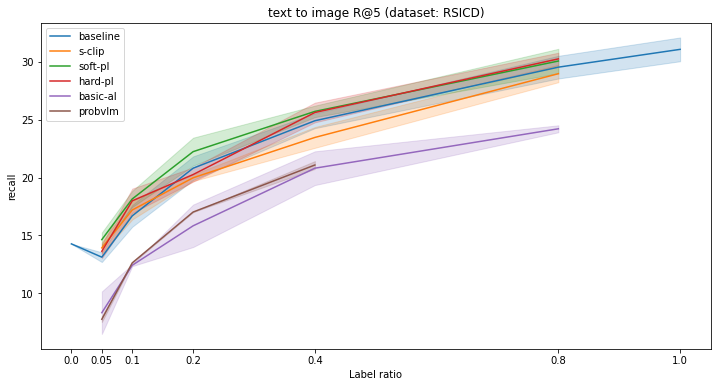

baseline text_to_image_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
21     0.00  None     UCM   base  text_to_image_R@5  64  0.00005       0.0   
219    0.05  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
2355   0.10  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
4491   0.20  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
7067   0.40  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
9619   0.80  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   
12141  1.00  None     UCM   base  text_to_image_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
21         0     NaN   False  31.430  0.000000     2  
219       25     NaN   False  35.142  3.341118     5  
2355      25     NaN   False  38.096  1.814657     5  
4491      25     NaN   False  48.666  1.033697     5  
7067      25     NaN   False  50.666  1.735578     5  
9619      25     NaN   False  55.334  1.824179     5  
12141     25     NaN   False  59.714  2.558062     5

s-clip text_to_image_R@5 UCM


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1389   0.05  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   
3525   0.10  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   
5661   0.20  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   
8277   0.40  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   
10821  0.80  ot.image     UCM   ours  text_to_image_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1389       25.0     25     NaN   False  36.096  1.829393     5  
3525       25.0     25     NaN   False  43.140  0.424853     5  
5661       25.0     25     NaN   False  52.950  0.849706     5  
8277       25.0     25     NaN   False  51.900  0.000000     5  
10821      25.0     25     NaN   False  58.854  1.489221     5

pad end: 1
soft-pl text_to_image_R@5 UCM


ratio         PL dataset method             metric  bs       lr  \
                                                                        
2099   0.05  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   
4235   0.10  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   
6371   0.20  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   
8987   0.40  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   
11531  0.80  soft.text     UCM   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
2099       30.0     30     NaN   False  38.192  3.292107     5  
4235       30.0     30     NaN   False  42.476  1.362289     5  
6371       30.0     30     NaN   False  46.474  0.926974     5  
8987       30.0     30     NaN   False  52.188  1.192841     5  
11531      30.0     30     NaN   False  57.618  1.431667     5

pad end: 1
hard-pl text_to_image_R@5 UCM


ratio         PL dataset method             metric  bs       lr  \
                                                                        
789    0.05  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   
2925   0.10  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   
5061   0.20  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   
7677   0.40  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   
10221  0.80  hard.text     UCM   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
789        25.0     25     NaN   False  35.430  3.755210     5  
2925       25.0     25     NaN   False  43.906  3.390403     5  
5061       25.0     25     NaN   False  48.476  3.202246     5  
7677       25.0     25     NaN   False  53.998  3.096784     5  
10221      25.0     25     NaN   False  59.808  2.553590     5

pad end: 1
basic-al text_to_image_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
214   0.05  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   
2350  0.10  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   
4486  0.20  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   
7042  0.40  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   
9594  0.80  None     UCM   base  text_to_image_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
214      20     2.0   False  33.428  1.915690     5  
2350     20     5.0   False  39.046  1.064368     5  
4486     20    10.0   False  42.856  1.344388     5  
7042     20    20.0   False  48.666  3.127496     5  
9594     20    40.0   False  52.858  1.303580     5

pad end: 1
probvlm text_to_image_R@5 UCM


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
213   0.05  None     UCM   base  text_to_image_R@5  32  0.00005      10.0   
2349  0.10  None     UCM   base  text_to_image_R@5  32  0.00005      10.0   
4485  0.20  None     UCM   base  text_to_image_R@5  32  0.00005      10.0   
7041  0.40  None     UCM   base  text_to_image_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
213      25     2.0    True  29.242  2.768252     5  
2349     25     5.0    True  36.190  0.000000     5  
4485     25    10.0    True  42.380  0.000000     5  
7041     25    20.0    True  45.528  2.768252     5

pad end: 2


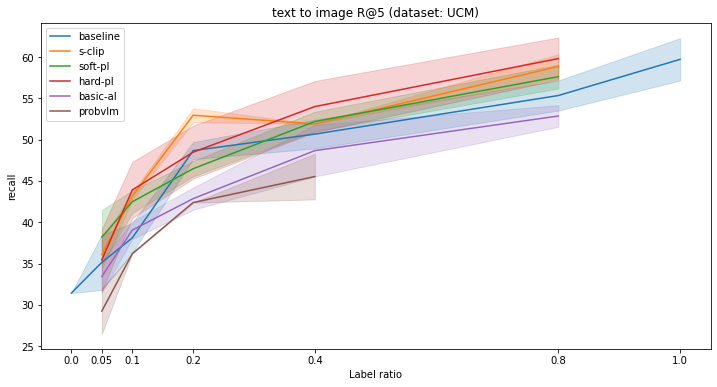

baseline text_to_image_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                             
15     0.00  None  Sydney   base  text_to_image_R@5  64  0.00005       0.0   
165    0.05  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
2301   0.10  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
4437   0.20  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
6893   0.40  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
9463   0.80  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   
11991  1.00  None  Sydney   base  text_to_image_R@5  64  0.00005      25.0   

      epochs AL.iter ProbVLM   value                  
                                mean       std count  
15         0     NaN   False  10.660  0.000000     2  
165       25     NaN   False  10.746  0.677370     5  
2301      25     NaN   False  14.406  1.293940     5  
4437      25     NaN   False  18.350  2.141775     5  
6893      25     NaN   False  27.044  1.087764     5  
9463      25     NaN   False  36.578  1.041091     5  
11991     25     NaN   False  37.666  0.438668     5

s-clip text_to_image_R@5 Sydney


ratio        PL dataset method             metric   bs       lr  \
                                                                        
1239   0.05  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   
3375   0.10  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   
5511   0.20  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   
8127   0.40  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   
10671  0.80  ot.image  Sydney   ours  text_to_image_R@5  128  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1239       25.0     25     NaN   False   9.742  1.077785     5  
3375       25.0     25     NaN   False  14.568  0.720014     5  
5511       25.0     25     NaN   False  17.140  0.357771     5  
8127       25.0     25     NaN   False  22.014  1.529470     5  
10671      25.0     25     NaN   False  31.710  0.178885     5

pad end: 1
soft-pl text_to_image_R@5 Sydney


ratio         PL dataset method             metric  bs       lr  \
                                                                        
1919   0.05  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   
4055   0.10  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   
6191   0.20  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   
8807   0.40  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   
11351  0.80  soft.text  Sydney   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
1919       30.0     30     NaN   False  11.146  2.197494     5  
4055       30.0     30     NaN   False  12.714  1.453850     5  
6191       30.0     30     NaN   False  17.382  0.719458     5  
8807       30.0     30     NaN   False  20.806  1.218536     5  
11351      30.0     30     NaN   False  27.848  0.442063     5

pad end: 1
hard-pl text_to_image_R@5 Sydney


ratio         PL dataset method             metric  bs       lr  \
                                                                        
639    0.05  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   
2775   0.10  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   
4911   0.20  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   
7527   0.40  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   
10071  0.80  hard.text  Sydney   ours  text_to_image_R@5  64  0.00005   

      AL.epochs epochs AL.iter ProbVLM   value                  
                                          mean       std count  
639        25.0     25     NaN   False   9.656  0.752350     5  
2775       25.0     25     NaN   False  12.876  0.493994     5  
4911       25.0     25     NaN   False  16.016  0.848664     5  
7527       25.0     25     NaN   False  21.328  1.865508     5  
10071      25.0     25     NaN   False  26.200  0.089443     5

pad end: 1
basic-al text_to_image_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
160   0.05  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   
2296  0.10  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   
4432  0.20  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   
6868  0.40  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   
9438  0.80  None  Sydney   base  text_to_image_R@5  64  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
160      20     2.0   False   8.250  0.648074     5  
2296     20     5.0   False  10.464  1.797799     5  
4432     20    10.0   False  16.096  4.025001     5  
6868     20    20.0   False  21.324  3.855967     5  
9438     20    40.0   False  33.122  1.763667     5

pad end: 1
probvlm text_to_image_R@5 Sydney


ratio    PL dataset method             metric  bs       lr AL.epochs  \
                                                                            
159   0.05  None  Sydney   base  text_to_image_R@5  32  0.00005      10.0   
2295  0.10  None  Sydney   base  text_to_image_R@5  32  0.00005      10.0   
4431  0.20  None  Sydney   base  text_to_image_R@5  32  0.00005      10.0   
6867  0.40  None  Sydney   base  text_to_image_R@5  32  0.00005      10.0   

     epochs AL.iter ProbVLM   value                  
                               mean       std count  
159      25     2.0    True   8.810  0.089443     5  
2295     25     5.0    True  13.480  0.000000     5  
4431     25    10.0    True  12.680  0.000000     5  
6867     25    20.0    True  15.978  0.718624     5

pad end: 2


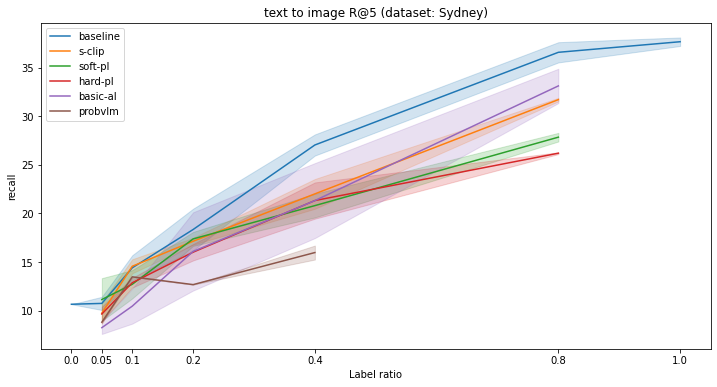

In [21]:
metric = 'text_to_image_R@5'
datasets = ['RSICD', 'UCM', 'Sydney']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)